In [1]:
import serial
import time

import matplotlib.pyplot as plt
from surya.debug.render_html import filepath
# %config InlineBackend.figure_formats = ['svg']

from analysis_lib import KeysightInfiniiVisionMSO, DEFAULT_LABELS
from analysis_lib.decoder import RawDecoder, RawDecodeResult, RawFrame, BrotherSerialDecoder, BrotherDecodeResult, DecodedByte
from analysis_lib.plotting import plot_digital, plot_digital_normalized
from analysis_lib.capture import Capture

ADDRESS = "USB0::2391::5925::MY49110266::INSTR"

INTERFACE = "IF60"
TYPEWRITER = "CE650"
KEYBOARD = 1 # Typenrad Selection Switch: 1=LOCAL, 2=INTERNATIONAL, 3=SYMBOL

switches = [
    0,  # 1-1: UP=RS-232C, DOWN=CDCC interface
    0,  # 1-2: UP=Terminal mode, DOWN=Printer mode
    1,  # 1-3: USA users can ignore
    1,  # 1-4: UP=ASCII Wheel, DOWN=Non-ASCII Wheel
    1,  # 1-5: UP=12-inch paper, DOWN=11-inch paper
    1,  # 1-6: UP=Auto skip perforation, DOWN=Non auto skip
        #
    1,  # 2-1: UP=Local echo (half-duplex), DOWN=No echo (full-duplex)
    1,  # 2-2: UP=DC-1/DC-3 disabled, DOWN=enabled
    1,  # 2-3: UP=Auto line feed off, DOWN=double spacing
    1,  # 2-4: UP=7-bit data, DOWN=8-bit data
    1,  # 2-5: UP=Even parity, DOWN=Odd parity
        #
    1,  # 2-6:  DOWN    DOWN    DOWN    DOWN    UP      UP      UP      UP
    1,  # 2-7:  DOWN    DOWN    UP      UP      DOWN    DOWN    UP      UP
    1,  # 2-8:  DOWN    UP      DOWN    UP      DOWN    UP      DOWN    UP
        # BAUD  9600    4800    2400    1200    600     300     150     110
]

DIP_SWITCHES = sum(bit << i for i, bit in enumerate(switches))

def setup_scope(time_scale=1.5e-4, delay=4.5e-4, trigger_channel=4, trigger_slope="NEGative"):
    """
    Quick scope setup for notebook use
    """
    scope = KeysightInfiniiVisionMSO(ADDRESS)

    scope.setup_digital_channels(
        channels=range(6),
        threshold=2.5,
        time_scale=time_scale,
    )

    for i, label in enumerate(DEFAULT_LABELS):
        scope.set_digital_label(i, label)

    scope.setup_digital_trigger(channel=trigger_channel, slope=trigger_slope)
    scope.set_trigger_delay(delay)

    return scope

In [5]:
# Capture STARTUP
# START WITH TYPEWRITER POWERED OFF AND turn it on right after running this cell!
NAME = "POWERON"
INFO = "Handshake between IF60 and CE650, after Power is supplied"

with setup_scope(time_scale=500e-3, delay=2000e-3, trigger_slope="NEGative") as scope:
    with serial.Serial(
        port='/dev/ttyUSB0',
        baudrate=9600,
        bytesize=serial.EIGHTBITS,    # Data Bits: 8
        stopbits=serial.STOPBITS_ONE, # Stop Bits: 1
        parity=serial.PARITY_NONE,    # Parity: None
        rtscts=True,                  # Hardware handshake
        timeout=1
    ) as con:

        # Arm the trigger (non-blocking)
        scope.arm_trigger()
        time.sleep(10)


        # Read the captured data
        time_data, packed, channel_data = scope.read_current_pod_data(pod=1, mode='RAW')

        # Segment based on idle time (1ms default = no activity for 1ms triggers split)
        captured_segments = scope.segment_long_capture(
            time_data, packed, channel_data,
            idle_threshold=10e-3,  # 1ms idle = new segment
            channels=[0, 1, 2, 3, 4, 5]  # Monitor all 6 channels
        )


ValueError: No device found.


Capture: POWERON_SEG0
Timestamp: 2026-01-27 13:15:34
Devices: CE650 / IF60
Data: 0.80 MHz, Channels: 0:SI, 1:SO, 2:SCK, 3:KBACK, 4:READY, 5:KBRQ, 6:D6, 7:D7
Notes: Handshake between IF60 and CE650, after Power is suppliedSegment NR.0

Segment 1 (timetag: 0.000ms) | SI: none | SO: none


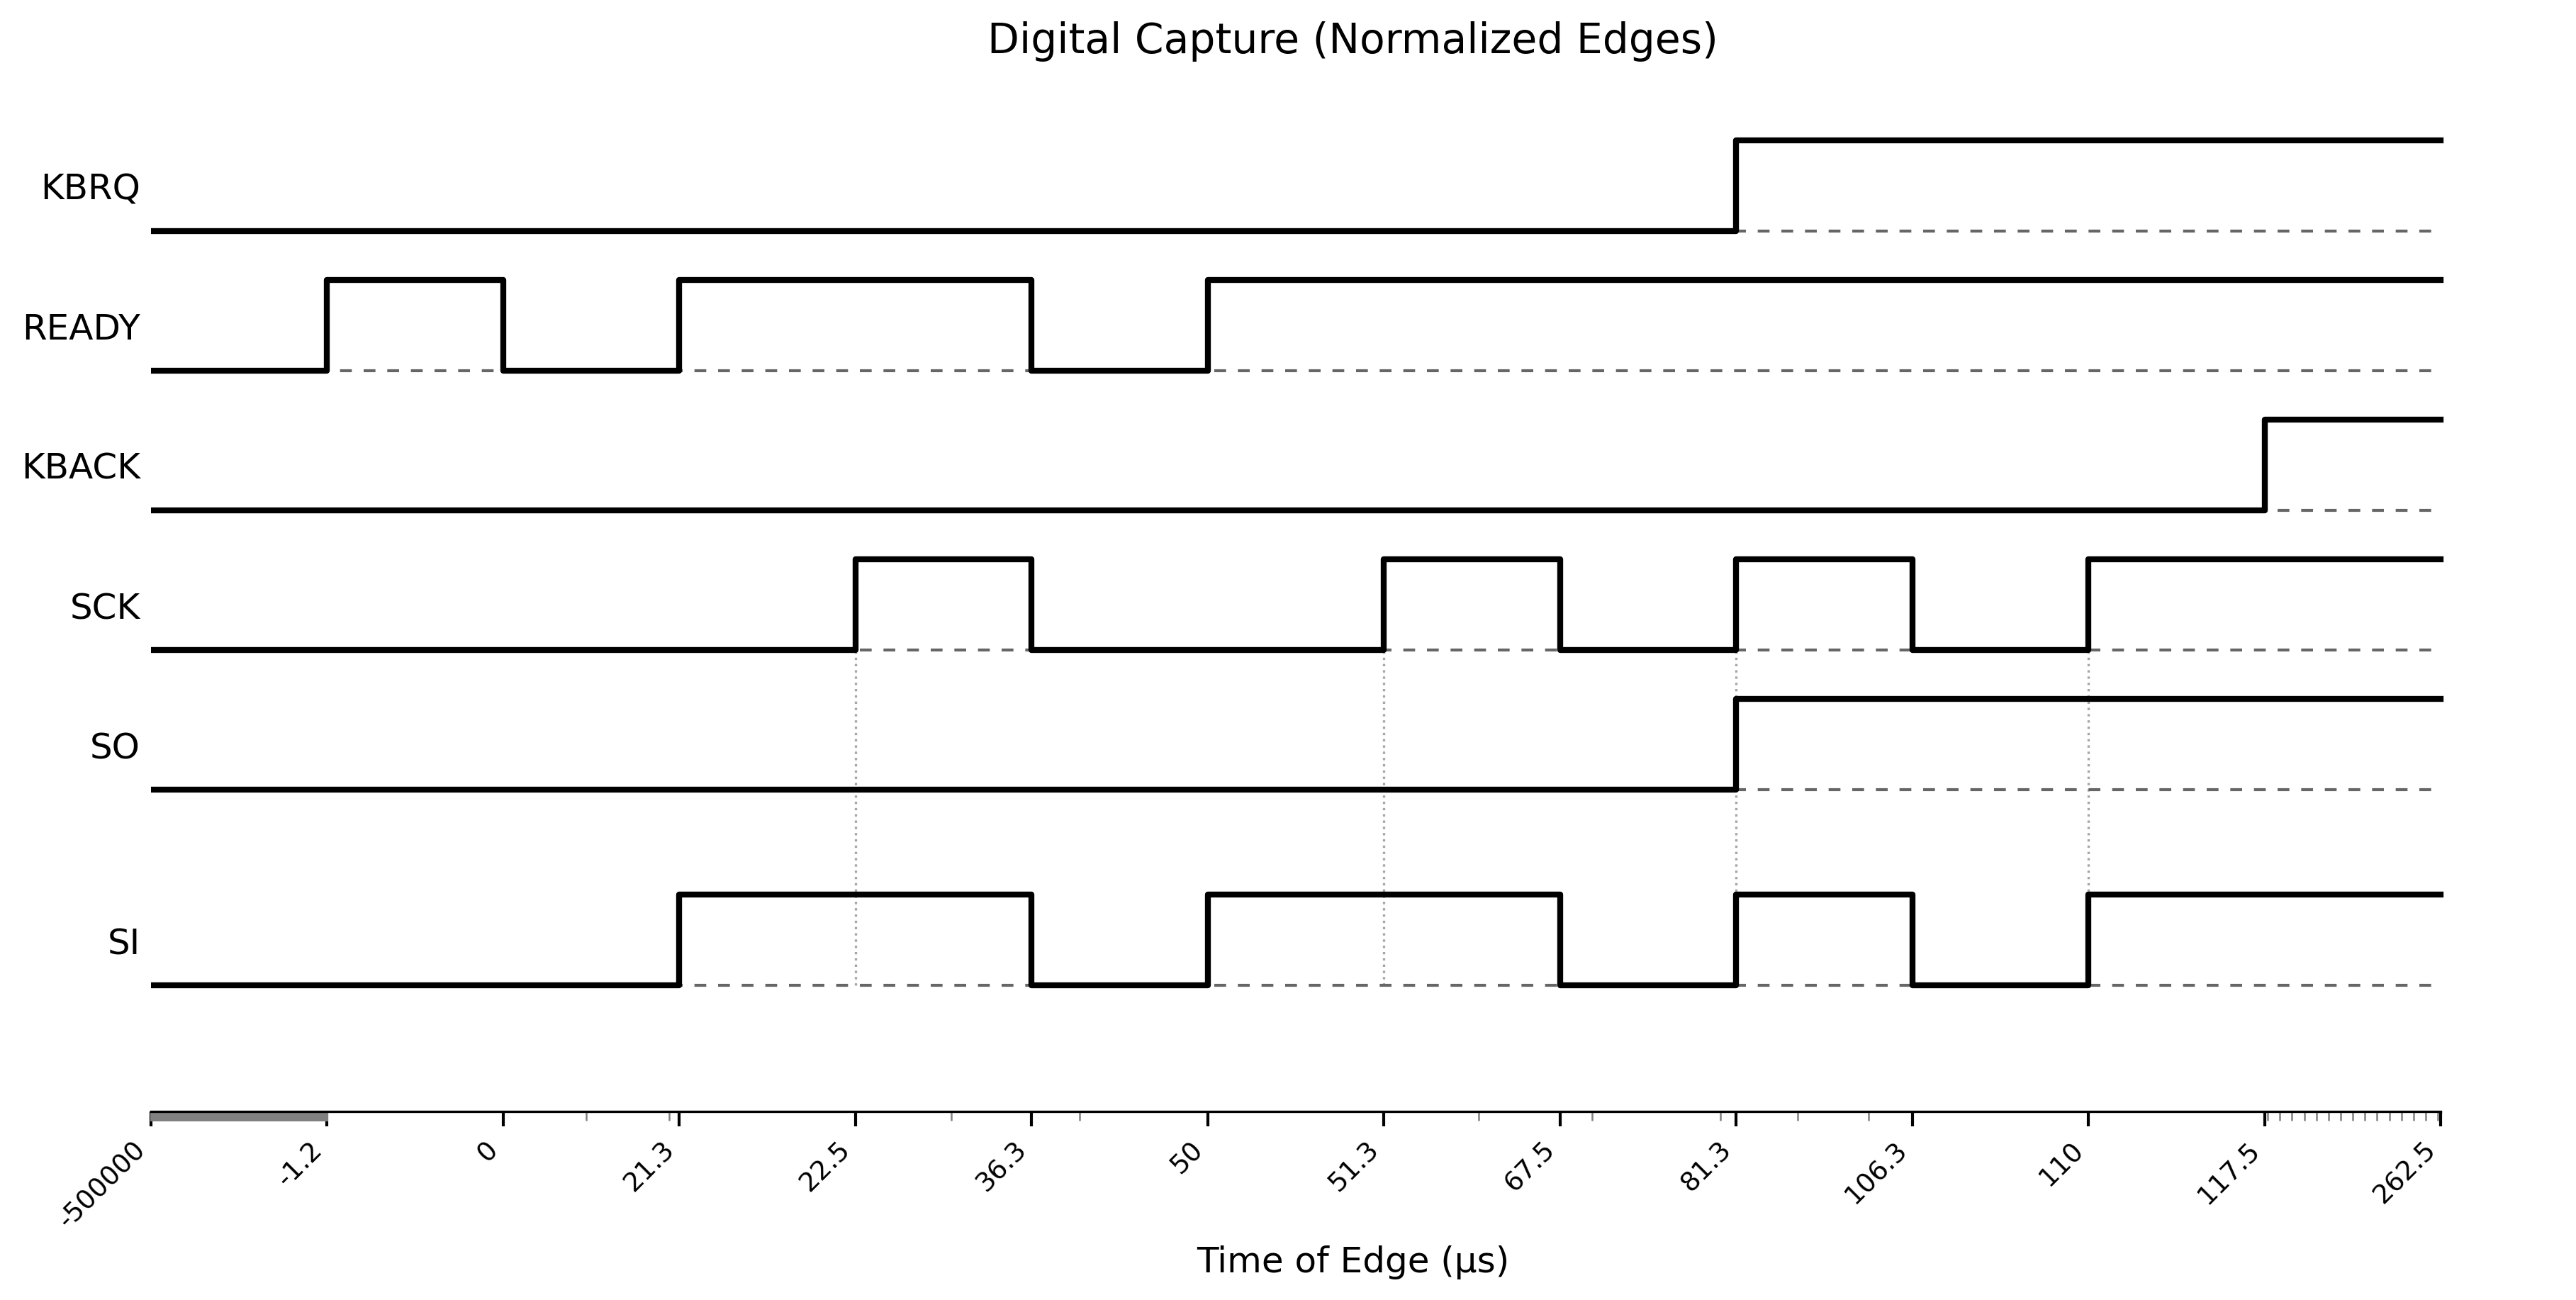


Capture: POWERON_SEG1
Timestamp: 2026-01-27 13:16:28
Devices: CE650 / IF60
Data: 0.80 MHz, Channels: 0:SI, 1:SO, 2:SCK, 3:KBACK, 4:READY, 5:KBRQ, 6:D6, 7:D7
Notes: Handshake between IF60 and CE650, after Power is suppliedSegment NR.1

Segment 2 (timetag: 515.101ms) | SI: none | SO: none


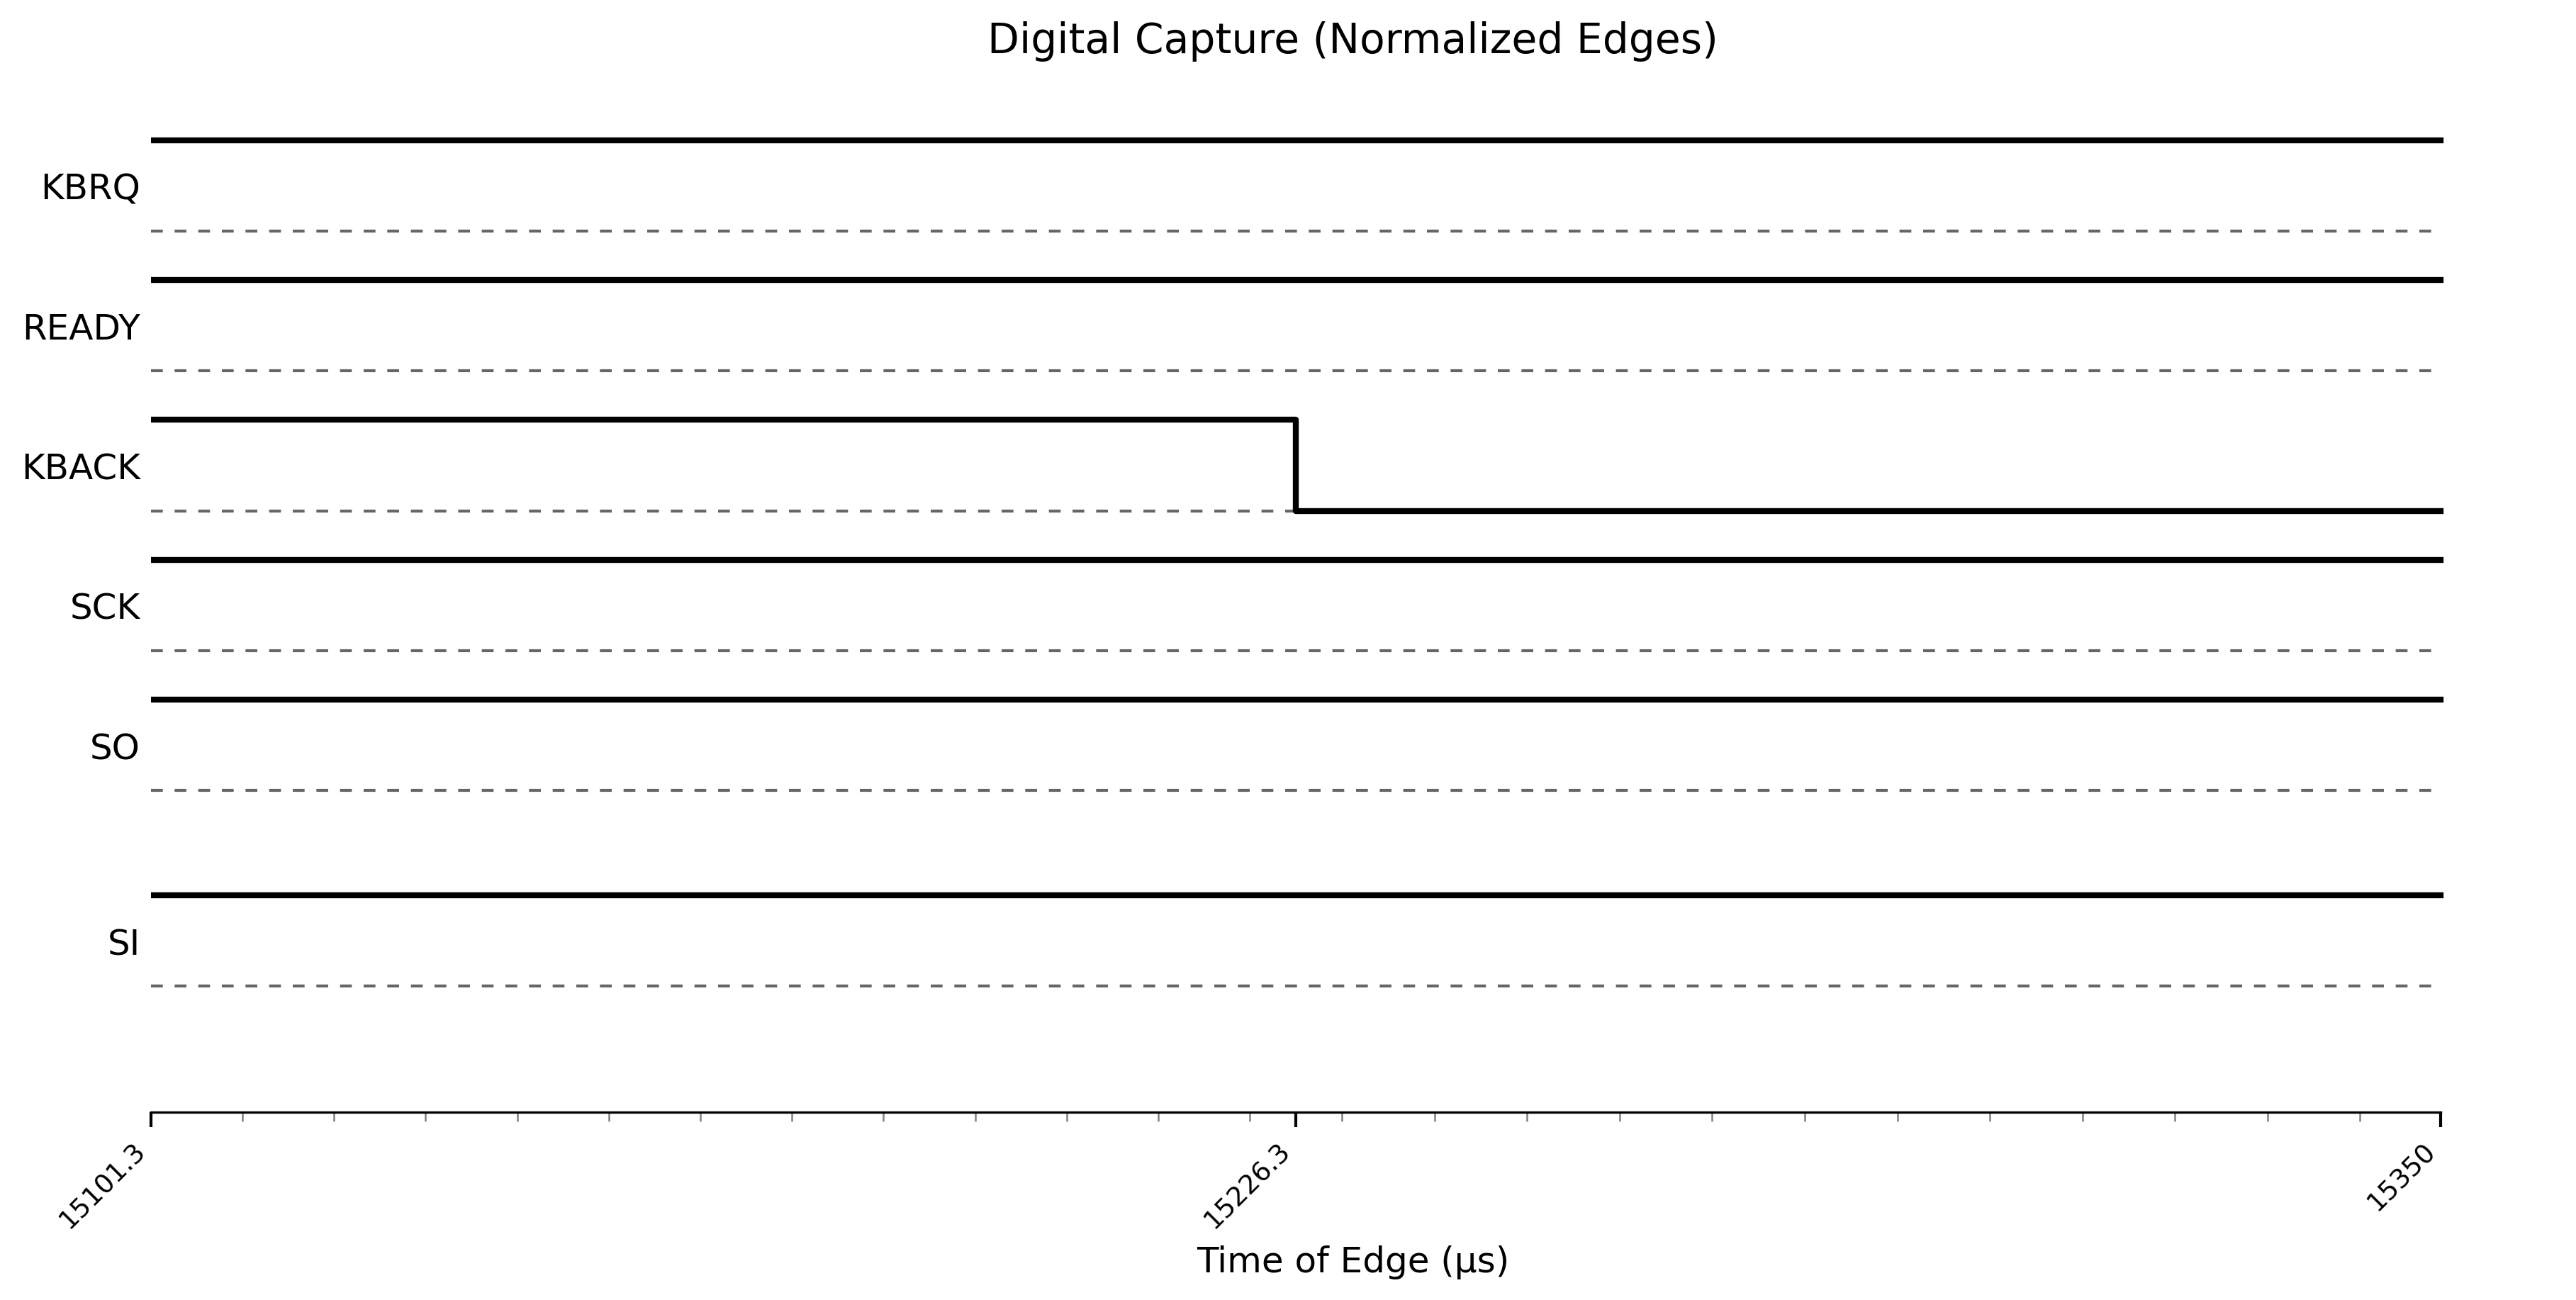


Capture: POWERON_SEG2
Timestamp: 2026-01-27 13:16:28
Devices: CE650 / IF60
Data: 0.80 MHz, Channels: 0:SI, 1:SO, 2:SCK, 3:KBACK, 4:READY, 5:KBRQ, 6:D6, 7:D7
Notes: Handshake between IF60 and CE650, after Power is suppliedSegment NR.2

Segment 3 (timetag: 997.059ms) | SI: none | SO: none


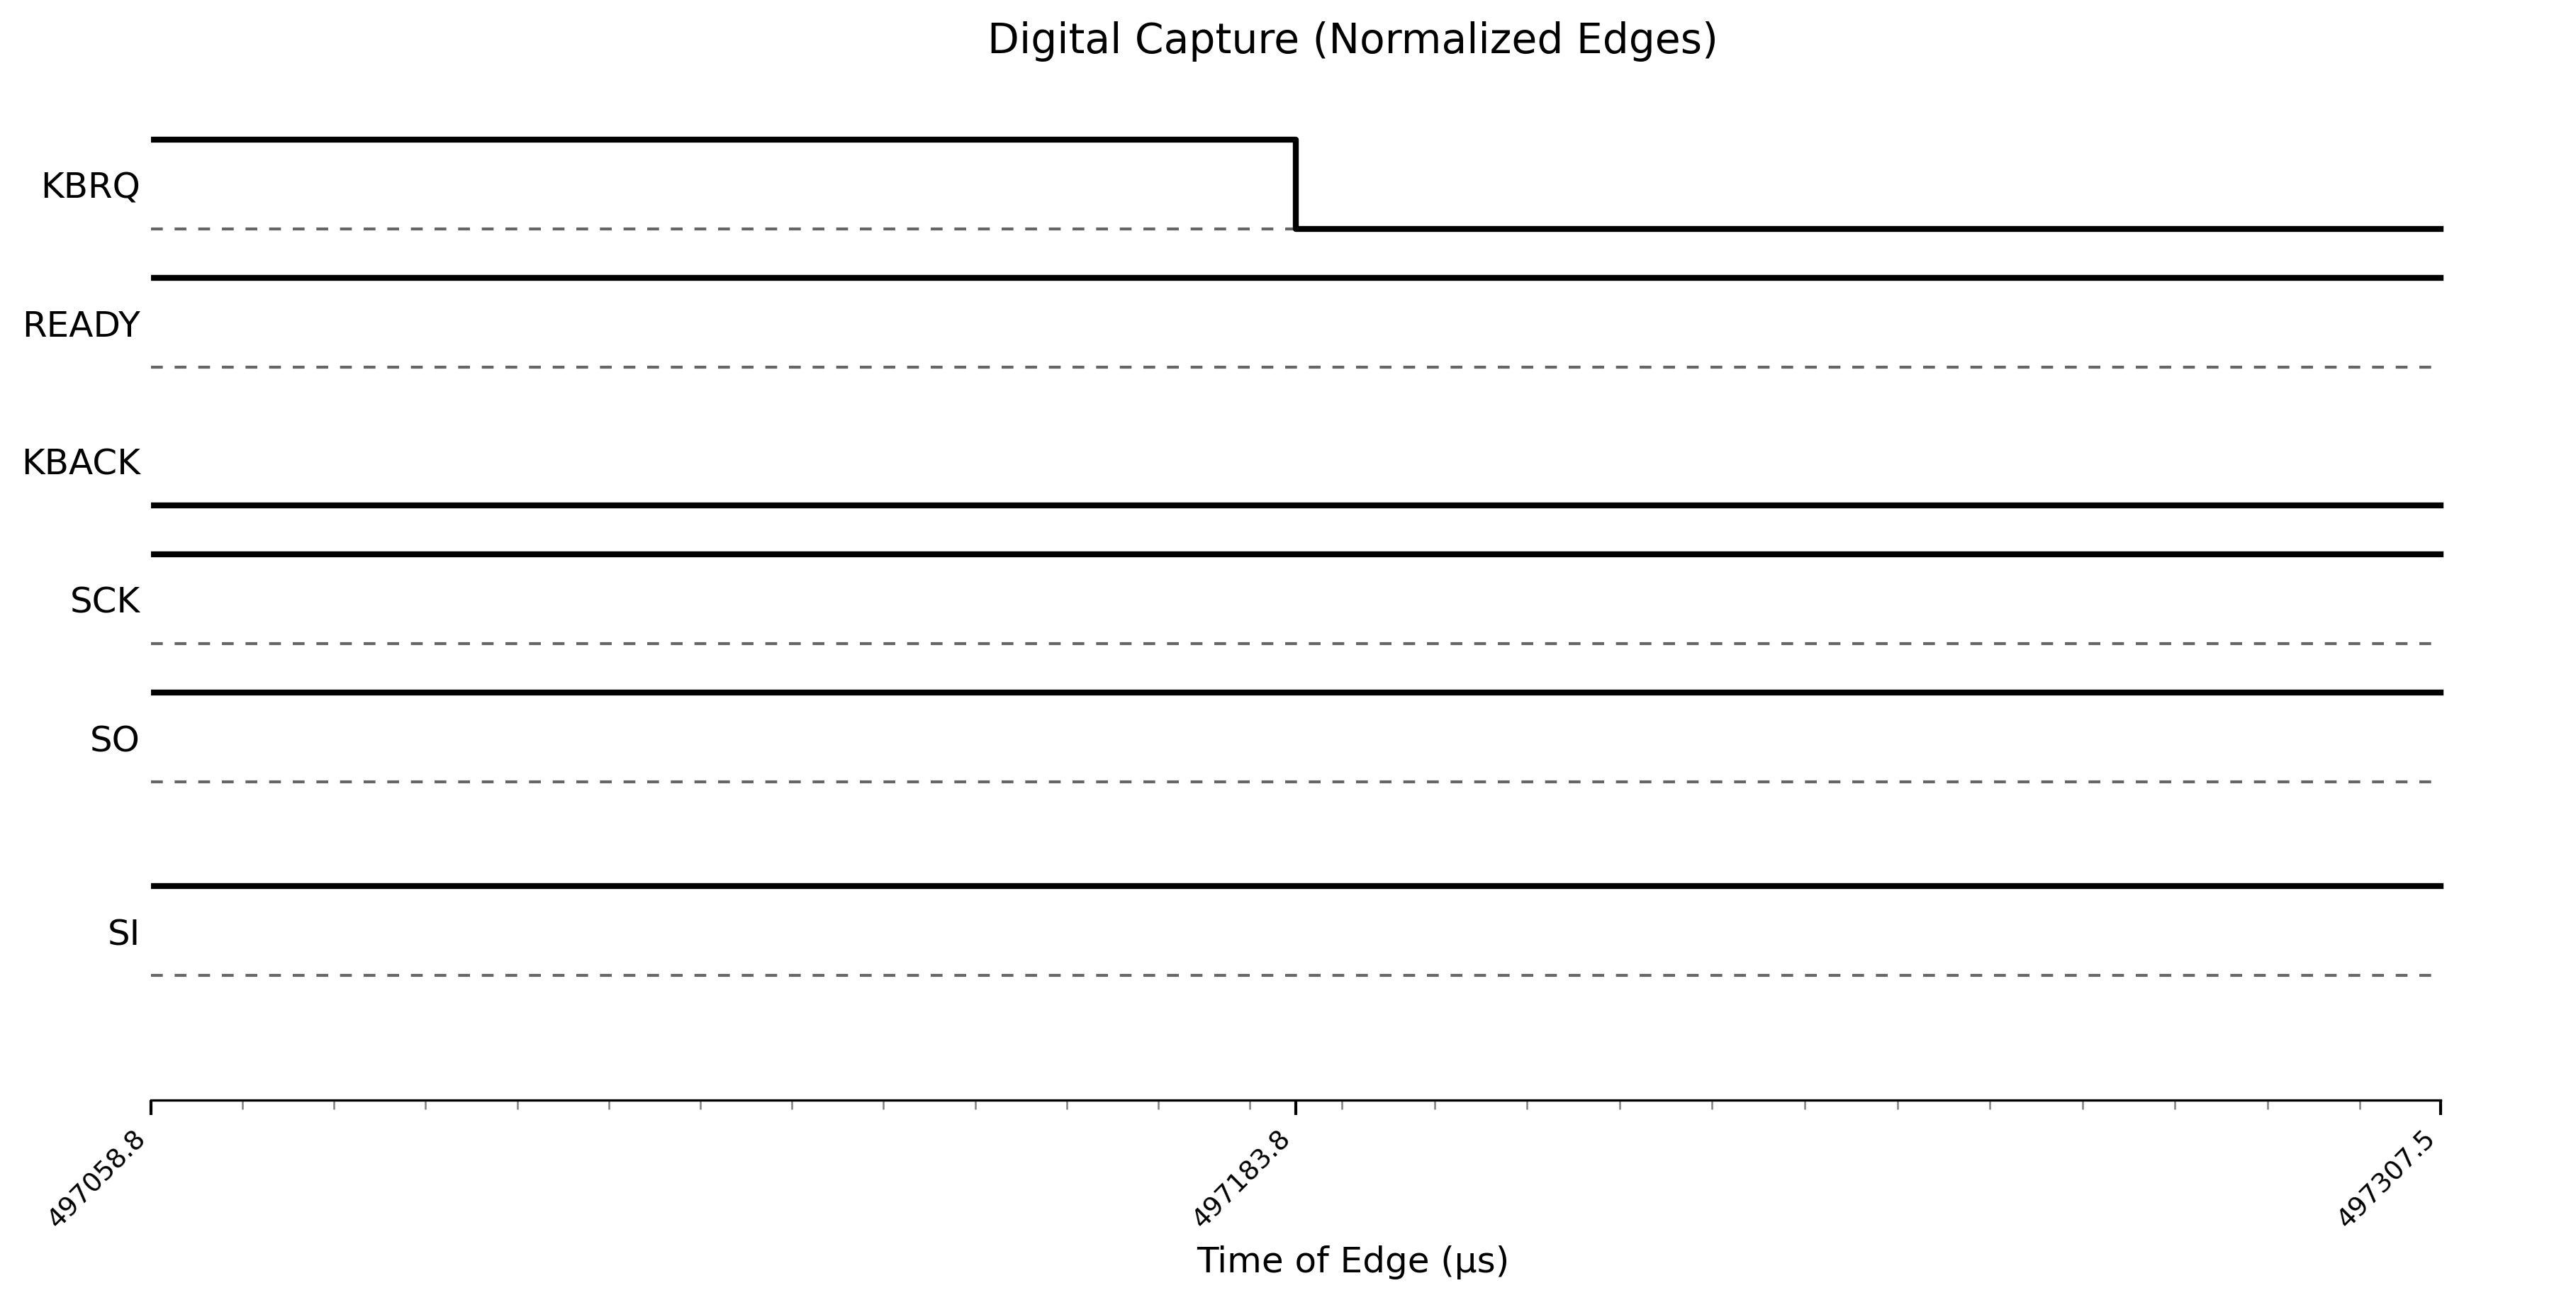


Capture: POWERON_SEG3
Timestamp: 2026-01-27 13:16:29
Devices: CE650 / IF60
Data: 0.80 MHz, Channels: 0:SI, 1:SO, 2:SCK, 3:KBACK, 4:READY, 5:KBRQ, 6:D6, 7:D7
Notes: Handshake between IF60 and CE650, after Power is suppliedSegment NR.3

Segment 4 (timetag: 1936.303ms) | SI: SOH | SO: NUL


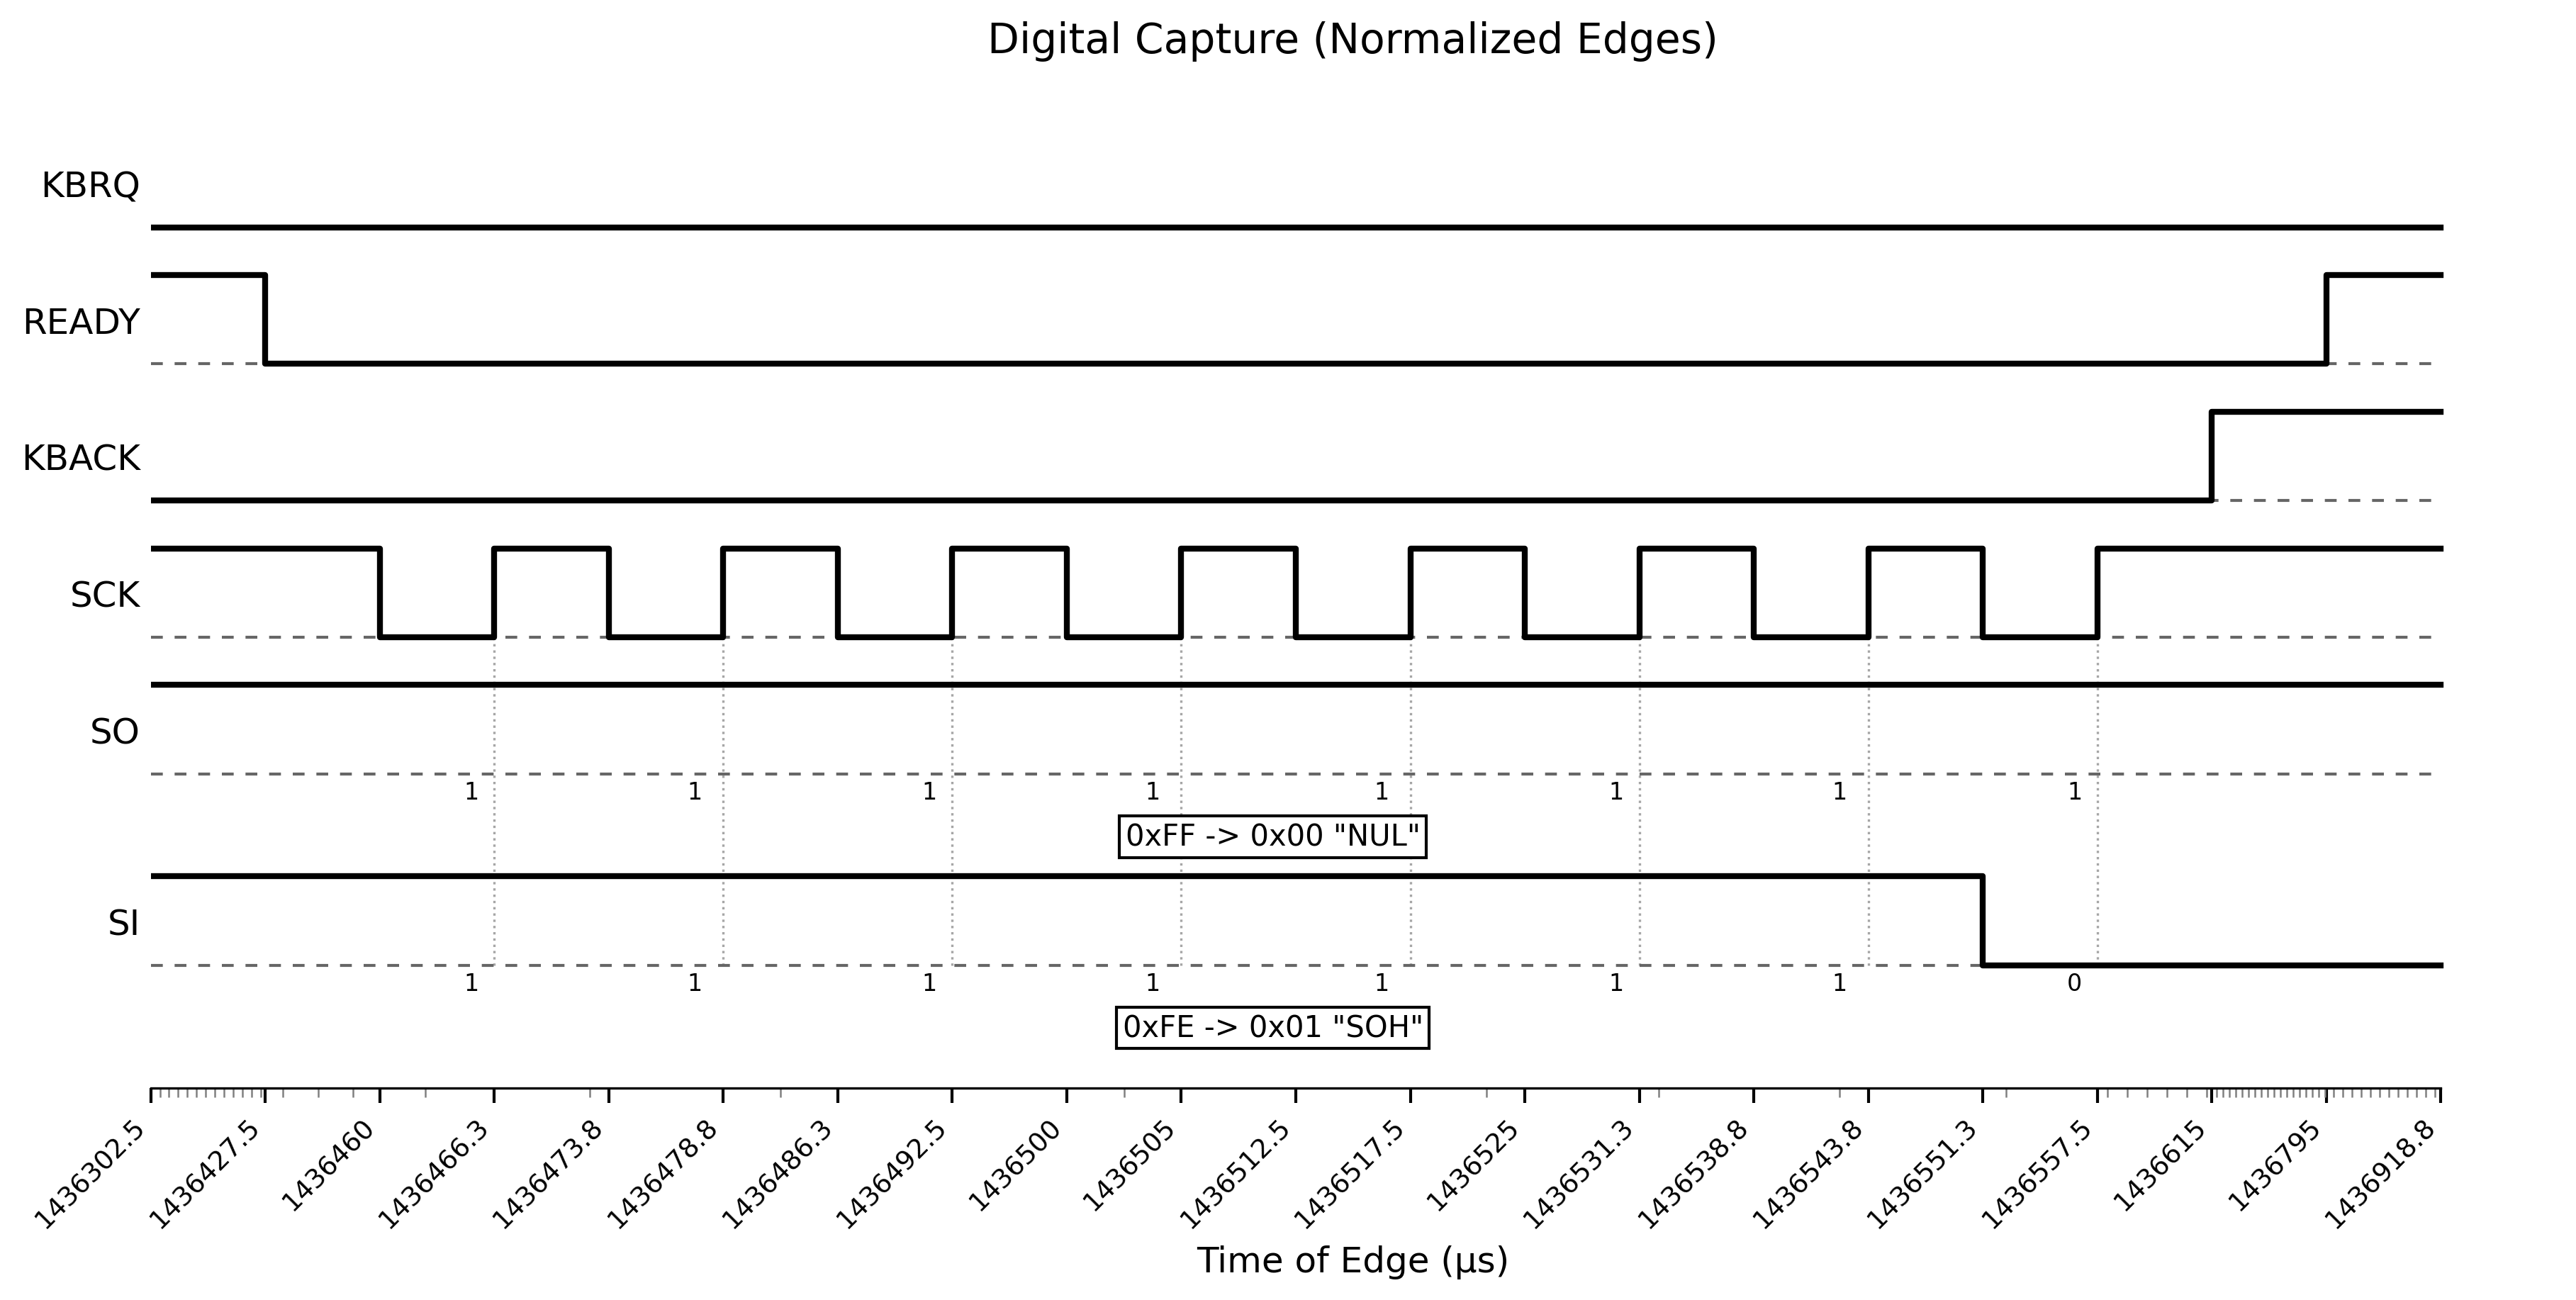


Capture: POWERON_SEG4
Timestamp: 2026-01-27 13:16:29
Devices: CE650 / IF60
Data: 0.80 MHz, Channels: 0:SI, 1:SO, 2:SCK, 3:KBACK, 4:READY, 5:KBRQ, 6:D6, 7:D7
Notes: Handshake between IF60 and CE650, after Power is suppliedSegment NR.4

Segment 5 (timetag: 3578.473ms) | SI: DEL | SO: j


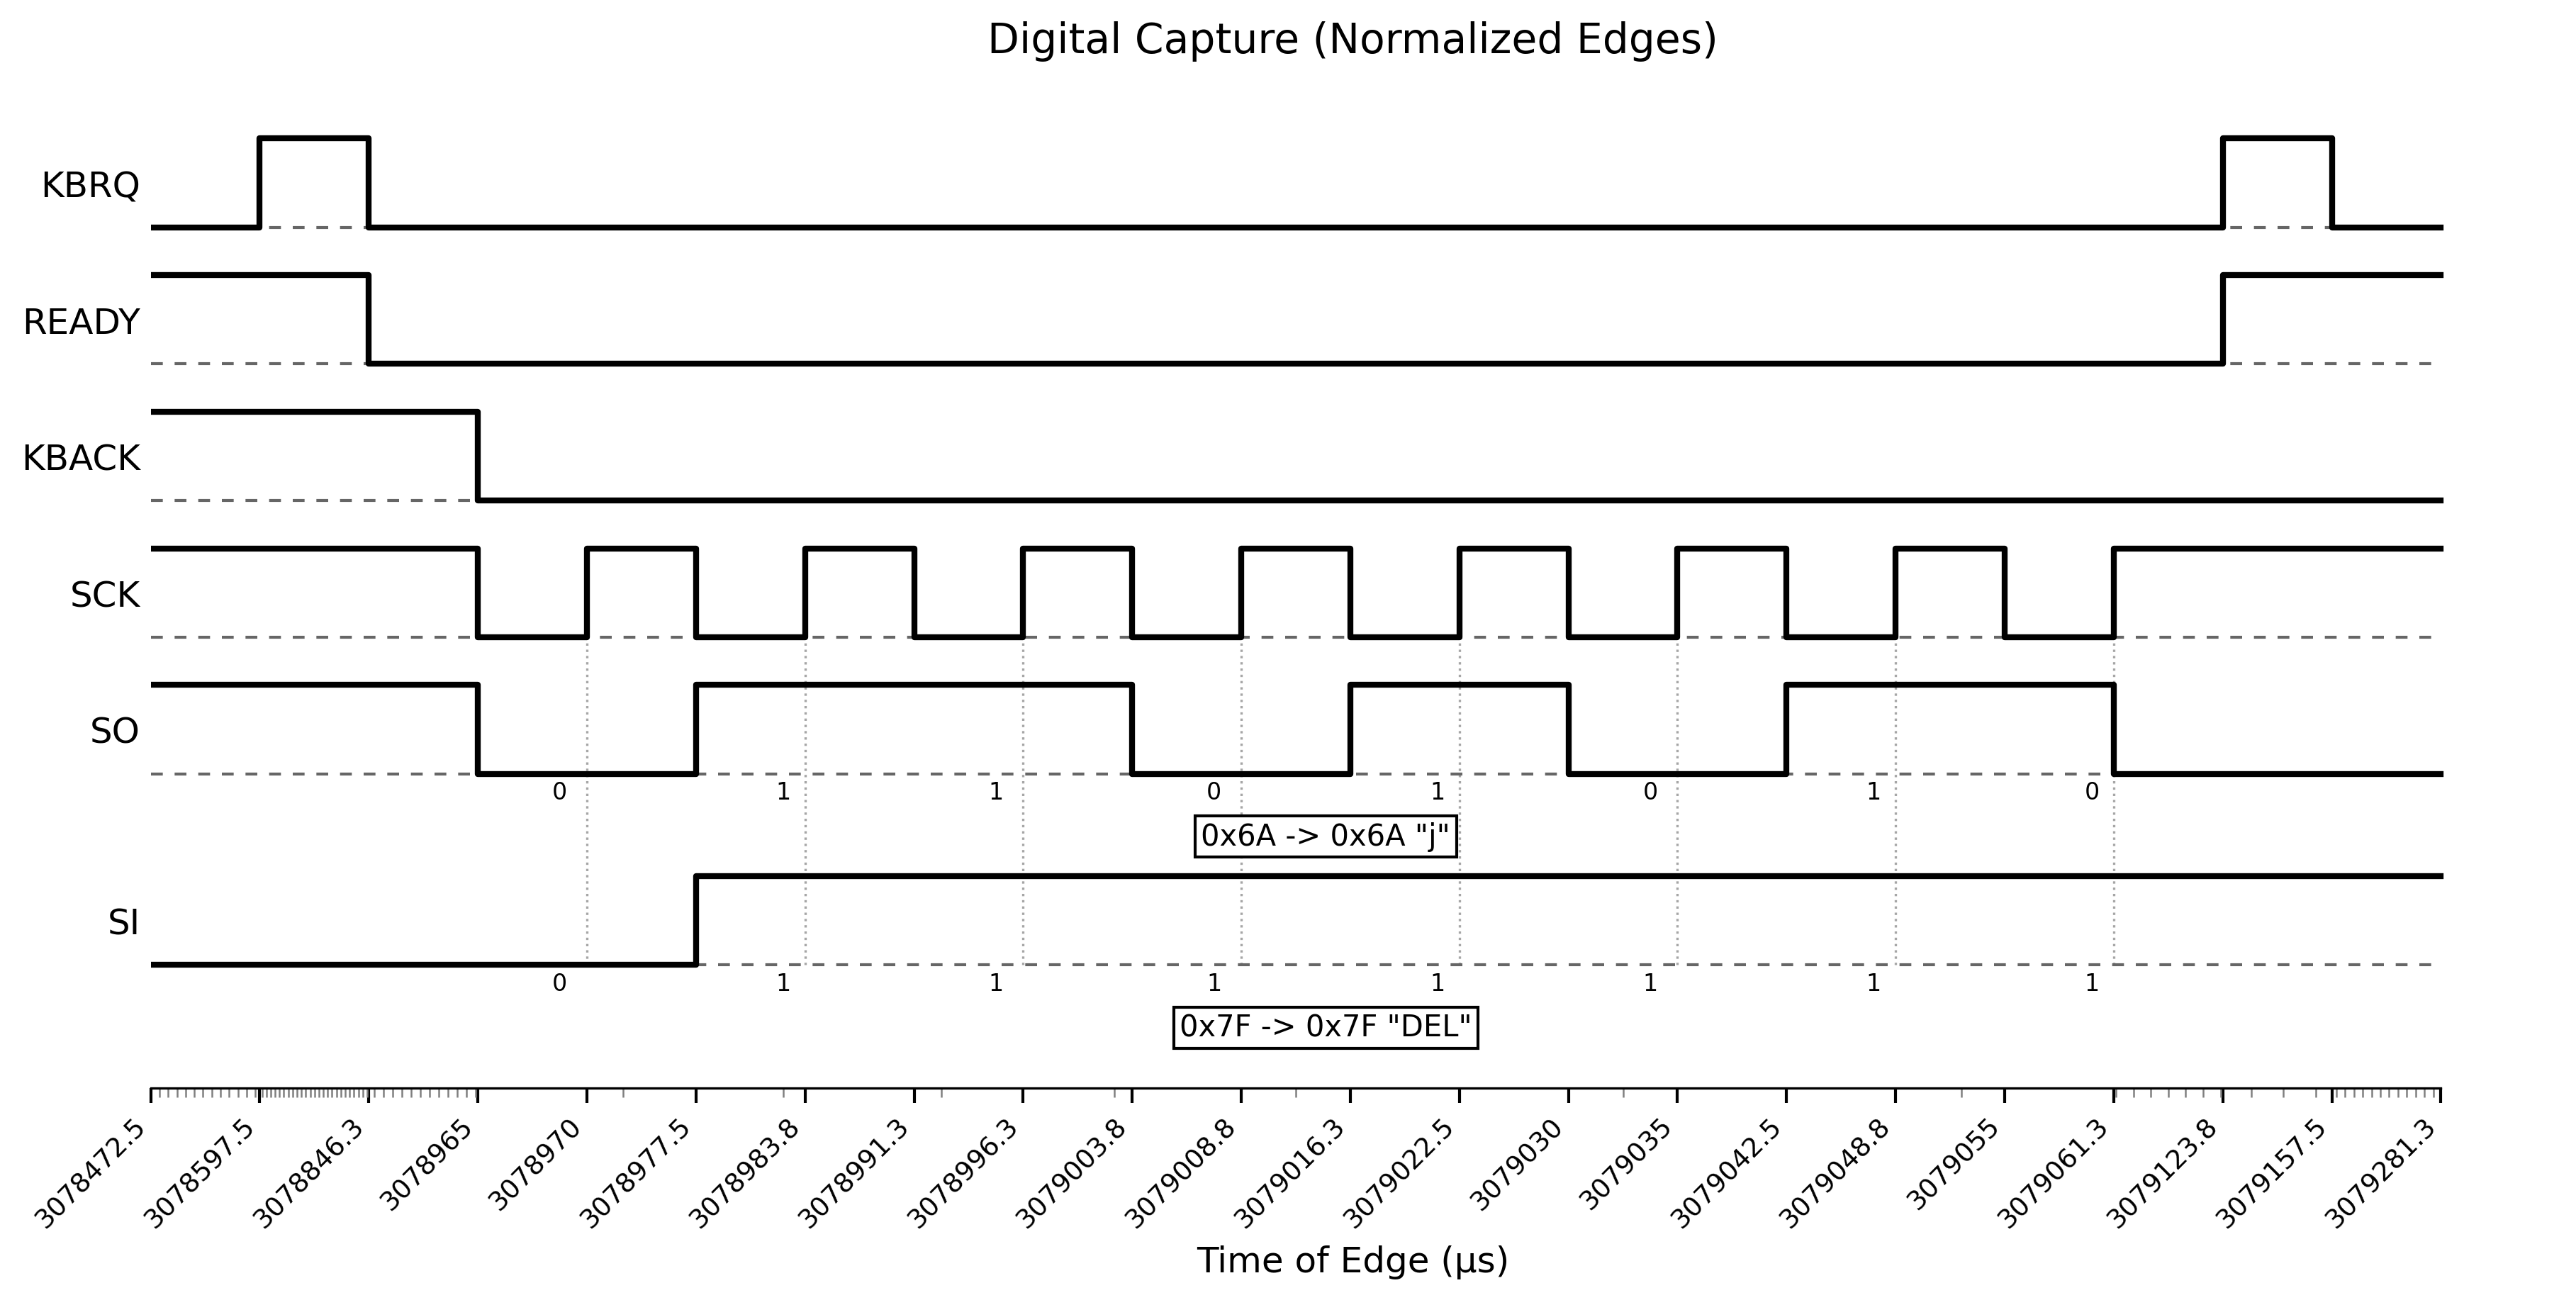

In [7]:
# Split Capture into segments
for seg_idx, segment_data in enumerate(captured_segments):
    time_data, packed, channel_data, timetag = segment_data

    # Create structured Capture with metadata
    capture = Capture.from_scope_data(
        time_data, packed, channel_data,
        typewriter=TYPEWRITER,
        interface=INTERFACE,
        name=NAME + f"_SEG{seg_idx}",
        info=INFO + f"Segment NR.{seg_idx}",
        keyboard_setting=KEYBOARD,
        interface_dip_switches=DIP_SWITCHES
    )

    # Print Captrure Info
    print(f"\n{capture.get_info()}")
    # Save Capture to file
    # filepath = capture.save(directory=f"./signal_captures/{TYPEWRITER}_{INTERFACE}")
    # print(f"Saved to: {filepath}\n")

    # Decode the data
    raw_decoder = RawDecoder(channel_data, time_data)
    raw_si = raw_decoder.decode(data_ch=0)
    raw_so = raw_decoder.decode(data_ch=1)

    decoded_si = BrotherSerialDecoder(raw_si).decode()
    decoded_so = BrotherSerialDecoder(raw_so).decode()

    # Build annotations
    annotations = (
        decoded_si.to_annotations(include_bits=True) +
        decoded_so.to_annotations(include_bits=True)
    )

    # Print segment info
    si_str = decoded_si.as_ascii() if len(decoded_si) > 0 else "none"
    so_str = decoded_so.as_ascii() if len(decoded_so) > 0 else "none"
    print(f"\nSegment {seg_idx + 1} (timetag: {timetag*1000:.3f}ms) | SI: {si_str} | SO: {so_str}")

    # Plot with annotations
    plot_digital_normalized(time_data, channel_data, annotations=annotations)


Connected to: AGILENT TECHNOLOGIES,MSO7014A,MY49110266,06.20.0000
Digital channels [0, 1, 2, 3, 4, 5] enabled, threshold=2.5V
Edge trigger on D4, slope=NEGative
Connection closed

Capture: SELECT
Timestamp: 2026-01-26 19:07:15
Devices: CE650 / IF60
Data: 200.00 MHz, Channels: 0:SI, 1:SO, 2:SCK, 3:KBACK, 4:READY, 5:KBRQ, 6:D6, 7:D7
Notes: Handshake between IF60 and CE650, after Transmission of DC1(Activates SEL Mode) from PC to Interface
RAW-SI: 0b11111001, 0b11111101, 0b01111111, 0b10100000, 0b11110100, 0b10110001, 0b00000110, 0b00000110, 0b11110010, 0b10100000, 0b10110001
RAW-SO: 0b11111111, 0b11111111, 0b00000100, 0b01111111, 0b11111111, 0b11111111, 0b11111111, 0b11111111, 0b11111111, 0b11111111, 0b11111111
DEC-SI: ACK,STX,DEL,_,VT,N,ACK,ACK,CR,_,N
DEC-SO: NUL,NUL,EOT,DEL,NUL,NUL,NUL,NUL,NUL,NUL,NUL


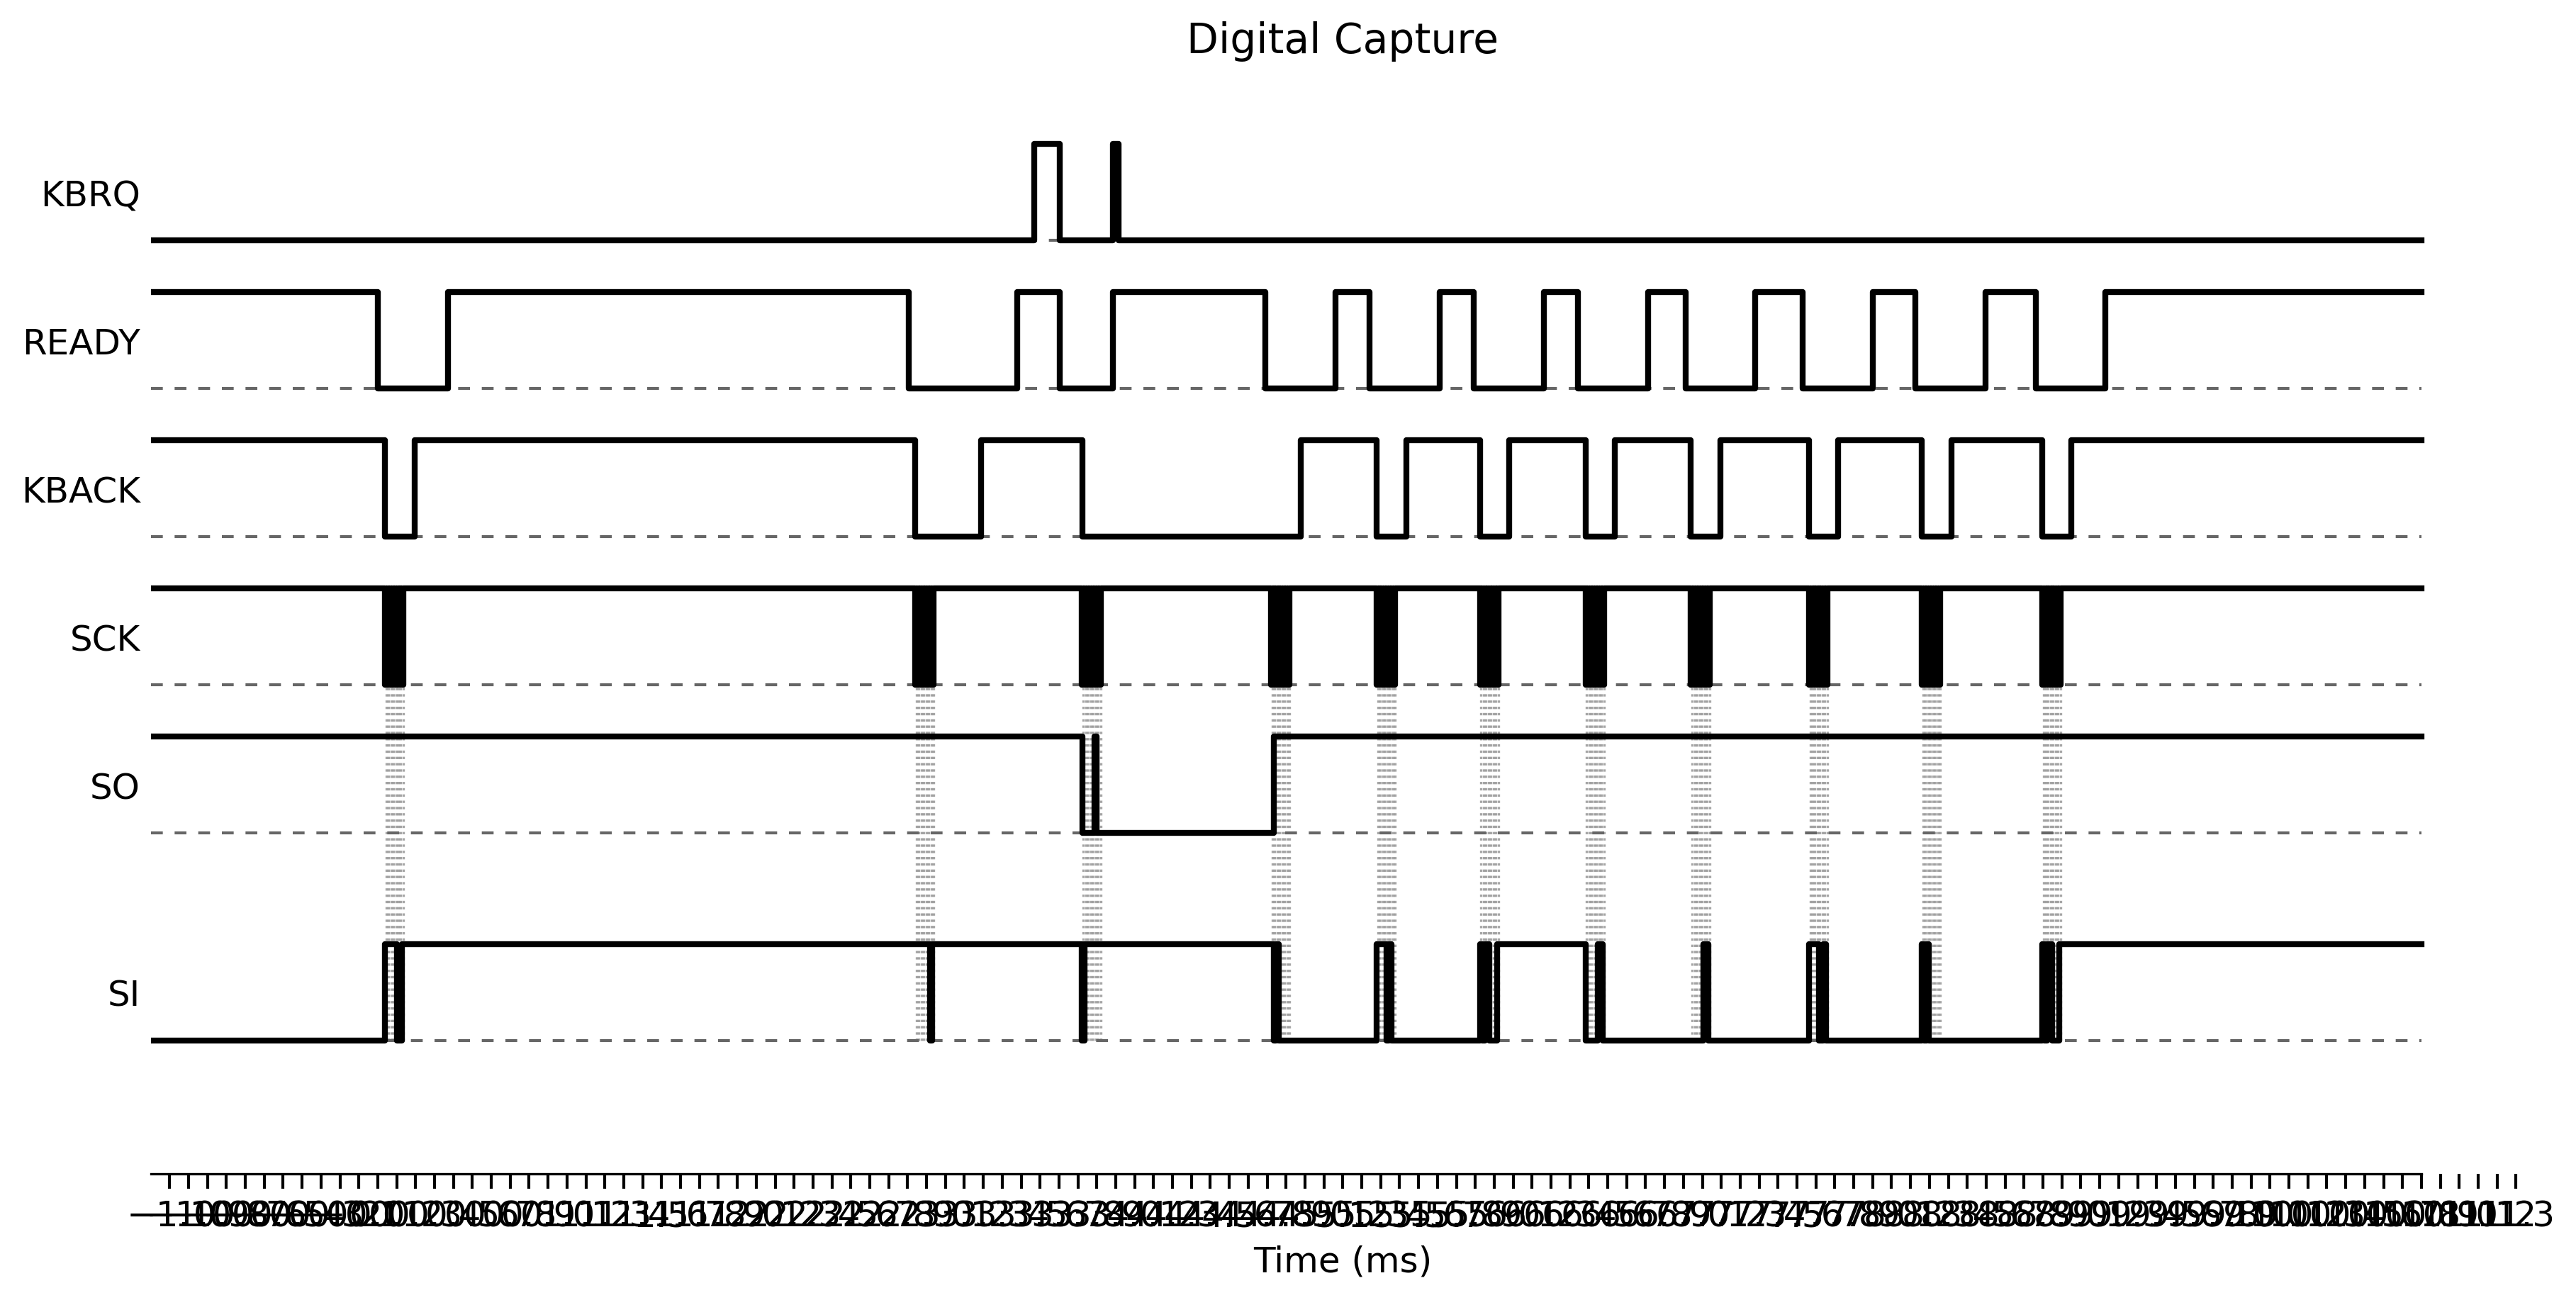

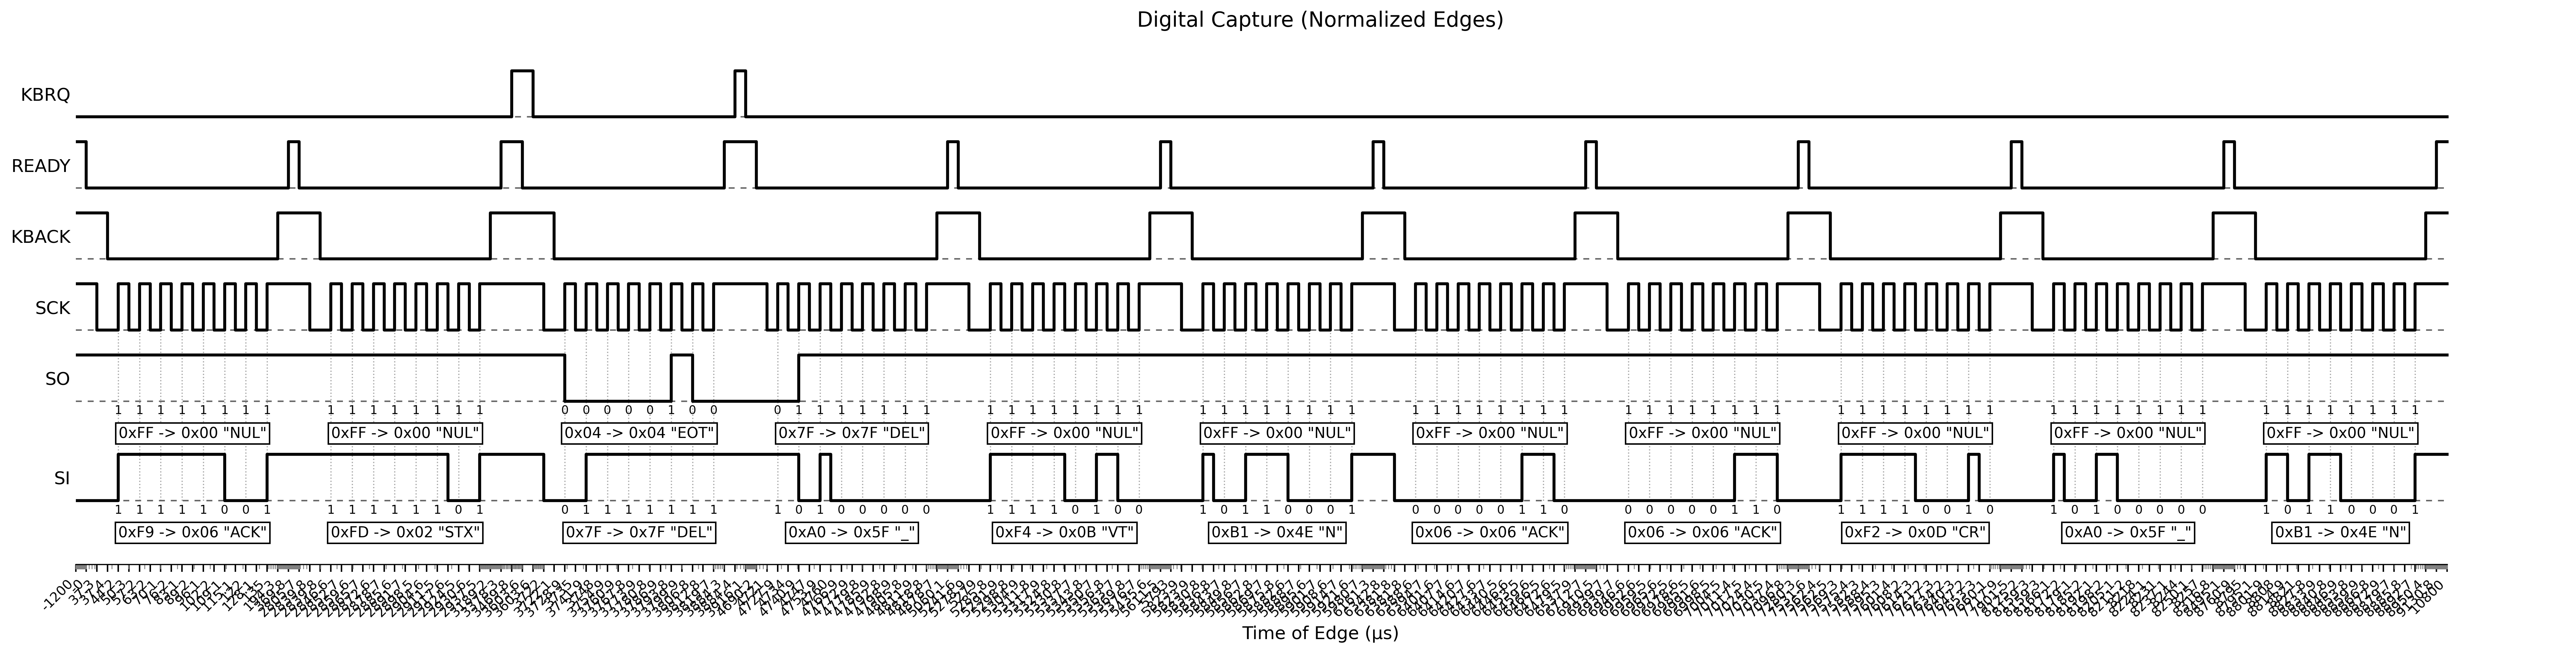

(<Figure size 7200x1800 with 1 Axes>,
 <Axes: title={'center': 'Digital Capture (Normalized Edges)'}, xlabel='Time of Edge (µs)'>)

In [3]:
# Capture Select
# START WITH INTERFACE IN DESELECTED STATE AND TYPEWRITER POWERED OFF AND ON BEFORE!
NAME = "SELECT"
INFO = "Handshake between IF60 and CE650, after Transmission of DC1(Activates SEL Mode) from PC to Interface"

with setup_scope(time_scale=1.2e-3, delay=4.8e-3, trigger_slope="NEGative") as scope:
    with serial.Serial(
        port='/dev/ttyUSB0',
        baudrate=9600,
        bytesize=serial.EIGHTBITS,    # Data Bits: 8
        stopbits=serial.STOPBITS_ONE, # Stop Bits: 1
        parity=serial.PARITY_NONE,    # Parity: None
        rtscts=True,                  # Hardware handshake
        timeout=1
    ) as con:

        # Arm the trigger (non-blocking)
        scope.arm_trigger()
        time.sleep(0.2)

        # DC1 Put IF-60 into Select State
        con.write(bytes([0x11]))
        time.sleep(5)

        # Read the captured data
        time_data, packed, channel_data = scope.read_current_pod_data(pod=1, mode='RAW')

# Create structured Capture with metadata
capture = Capture.from_scope_data(
    time_data, packed, channel_data,
    typewriter=TYPEWRITER,
    interface=INTERFACE,
    name=NAME,
    info=INFO,
    keyboard_setting=KEYBOARD,
    interface_dip_switches=DIP_SWITCHES
)

# Print Captrure Info
print(f"\n{capture.get_info()}")
# Save Capture to file
# filepath = capture.save(directory=f"./signal_captures/{TYPEWRITER}_{INTERFACE}")
# print(f"Saved to: {filepath}\n")

# Decode and Debounce Raw Bits
raw_decoder = RawDecoder(channel_data, time_data)
raw_si: RawDecodeResult = raw_decoder.decode(data_ch=0)
raw_so: RawDecodeResult = raw_decoder.decode(data_ch=1)
print(f"RAW-SI: {raw_si}\nRAW-SO: {raw_so}")

decoded_si = BrotherSerialDecoder(raw_si).decode()
decoded_so = BrotherSerialDecoder(raw_so).decode()
print(f"DEC-SI: {decoded_si}\nDEC-SO: {decoded_so}")

# Plot with annotations
annotations = (decoded_si.to_annotations(include_bits=True) + decoded_so.to_annotations(include_bits=True))

plot_digital(time_data, channel_data)
plot_digital_normalized(time_data, channel_data, annotations=annotations, figsize=(24,6))


In [10]:
# Capture ASCII
# START WITH INTERFACE IN SELECTED STATE AND TYPEWRITER POWERED OFF AND ON BEFORE!

import numpy as np
import pandas as pd

with setup_scope(time_scale=0.6e-4, delay=2.4e-4, trigger_slope="NEGative") as scope:
    with serial.Serial(
        port='/dev/ttyUSB0',
        baudrate=9600,
        bytesize=serial.EIGHTBITS,    # Data Bits: 8
        stopbits=serial.STOPBITS_ONE, # Stop Bits: 1
        parity=serial.PARITY_NONE,    # Parity: None
        rtscts=True,                  # Hardware handshake
        timeout=1
    ) as con:
        # Array to capture output
        result_list = []

        # Loop all Chars from 33 upto 126
        for i in range(33,127):

            # Special Chars where More is send then one bit. Next cell
            if i in [60, 62, 94]:
                continue


            # Arm the trigger (non-blocking)
            scope.arm_trigger()
            time.sleep(0.1)

            # Send Char
            con.write(bytes([i]))
            time.sleep(0.1)

            # Read the captured data
            time_data, packed, channel_data = scope.read_current_pod_data(pod=1, mode='NORMal')

            if i % 20 == 0:
                # Send CR
                con.write(bytes([0x0D]))
                time.sleep(2)

            # Create structured Capture with metadata
            capture = Capture.from_scope_data(
                time_data, packed, channel_data,
                typewriter=TYPEWRITER,
                interface=INTERFACE,
                name=f"ASCII_{i}",
                info=f'Transmission from IF60 to AX650, after sending Ascii letter "{chr(i)}" to IF60 from PC ',
                keyboard_setting=KEYBOARD,
                interface_dip_switches=DIP_SWITCHES
            )

            # Print Captrure Info
            # print(f"\n{capture.get_info()}")
            # Save Capture to file
            # filepath = capture.save(directory=f"./signal_captures/{TYPEWRITER}_{INTERFACE}")
            # print(f"Saved to: {filepath}\n")

            # Decode and Debounce Raw Bits
            raw_decoder = RawDecoder(channel_data, time_data)
            raw_si: RawDecodeResult = raw_decoder.decode(data_ch=0)

            decoded_si = BrotherSerialDecoder(raw_si).decode()
            decoded_so = BrotherSerialDecoder(raw_so).decode()
            print(f"PC: {i}, IF60: {decoded_si.bytes[0].raw_value} ASCII: {chr(decoded_si.bytes[0].raw_value)}")
            result_list.append((i, decoded_si.bytes[0].raw_value))

    df = pd.DataFrame(result_list, columns=["PC", "IF60"])

Connected to: AGILENT TECHNOLOGIES,MSO7014A,MY49110266,06.20.0000
Digital channels [0, 1, 2, 3, 4, 5] enabled, threshold=2.5V
Edge trigger on D4, slope=NEGative
Saved to: signal_captures/CE650_IF60/CE650_IF60_ASCII_33.pkl

PC: 33, IF60: 33 ASCII: !
Saved to: signal_captures/CE650_IF60/CE650_IF60_ASCII_34.pkl

PC: 34, IF60: 64 ASCII: @
Saved to: signal_captures/CE650_IF60/CE650_IF60_ASCII_35.pkl

PC: 35, IF60: 92 ASCII: \
Saved to: signal_captures/CE650_IF60/CE650_IF60_ASCII_36.pkl

PC: 36, IF60: 36 ASCII: $
Saved to: signal_captures/CE650_IF60/CE650_IF60_ASCII_37.pkl

PC: 37, IF60: 37 ASCII: %
Saved to: signal_captures/CE650_IF60/CE650_IF60_ASCII_38.pkl

PC: 38, IF60: 32 ASCII:  
Saved to: signal_captures/CE650_IF60/CE650_IF60_ASCII_39.pkl

PC: 39, IF60: 96 ASCII: `
Saved to: signal_captures/CE650_IF60/CE650_IF60_ASCII_40.pkl

PC: 40, IF60: 42 ASCII: *
Saved to: signal_captures/CE650_IF60/CE650_IF60_ASCII_41.pkl

PC: 41, IF60: 40 ASCII: (
Saved to: signal_captures/CE650_IF60/CE650_IF60

Connected to: AGILENT TECHNOLOGIES,MSO7014A,MY49110266,06.20.0000
Digital channels [0, 1, 2, 3, 4, 5] enabled, threshold=2.5V
Edge trigger on D4, slope=NEGative
Saved to: signal_captures/CE650_IF60/CE650_IF60_ASCII_60_SPECIAL.pkl

PC: 60 "<"
RAW-SI: 0b10001000, 0b01011000, 0b10001001
RAW-SO: 0b11111111, 0b11111111, 0b11111111
DEC-SI: w,X,v
DEC-SO: NUL,NUL,NUL


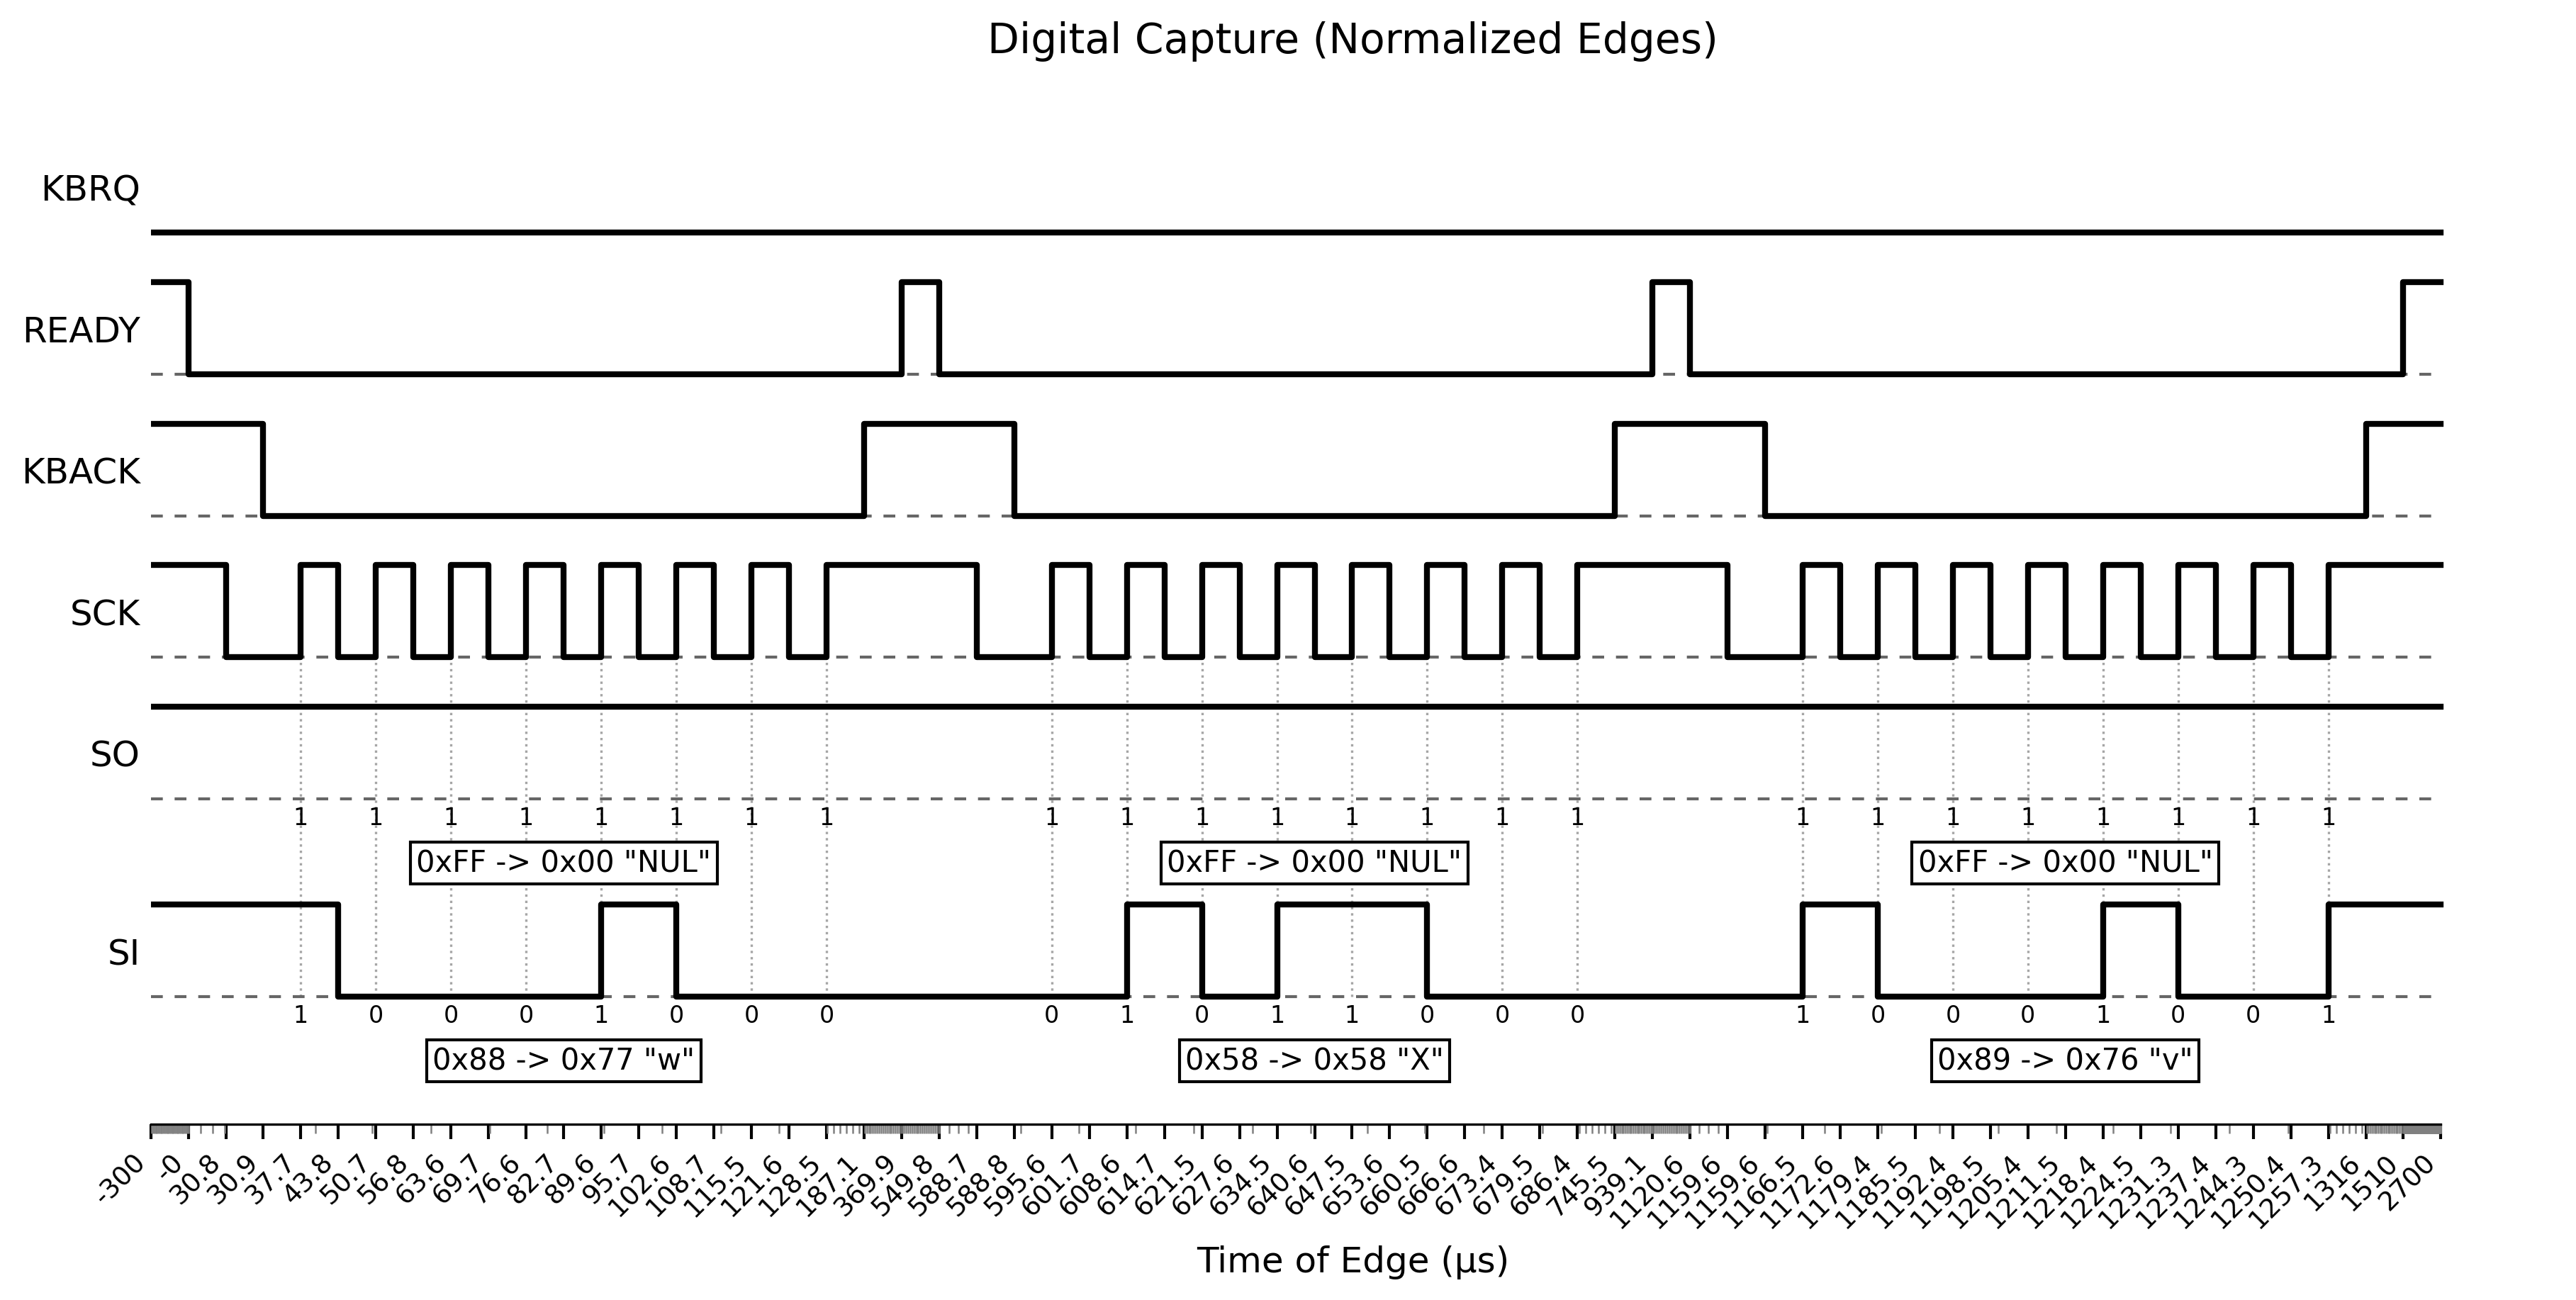

Saved to: signal_captures/CE650_IF60/CE650_IF60_ASCII_62_SPECIAL.pkl

PC: 62 ">"
RAW-SI: 0b10001000, 0b01010110, 0b10001001
RAW-SO: 0b11111111, 0b11111111, 0b11111111
DEC-SI: w,V,v
DEC-SO: NUL,NUL,NUL


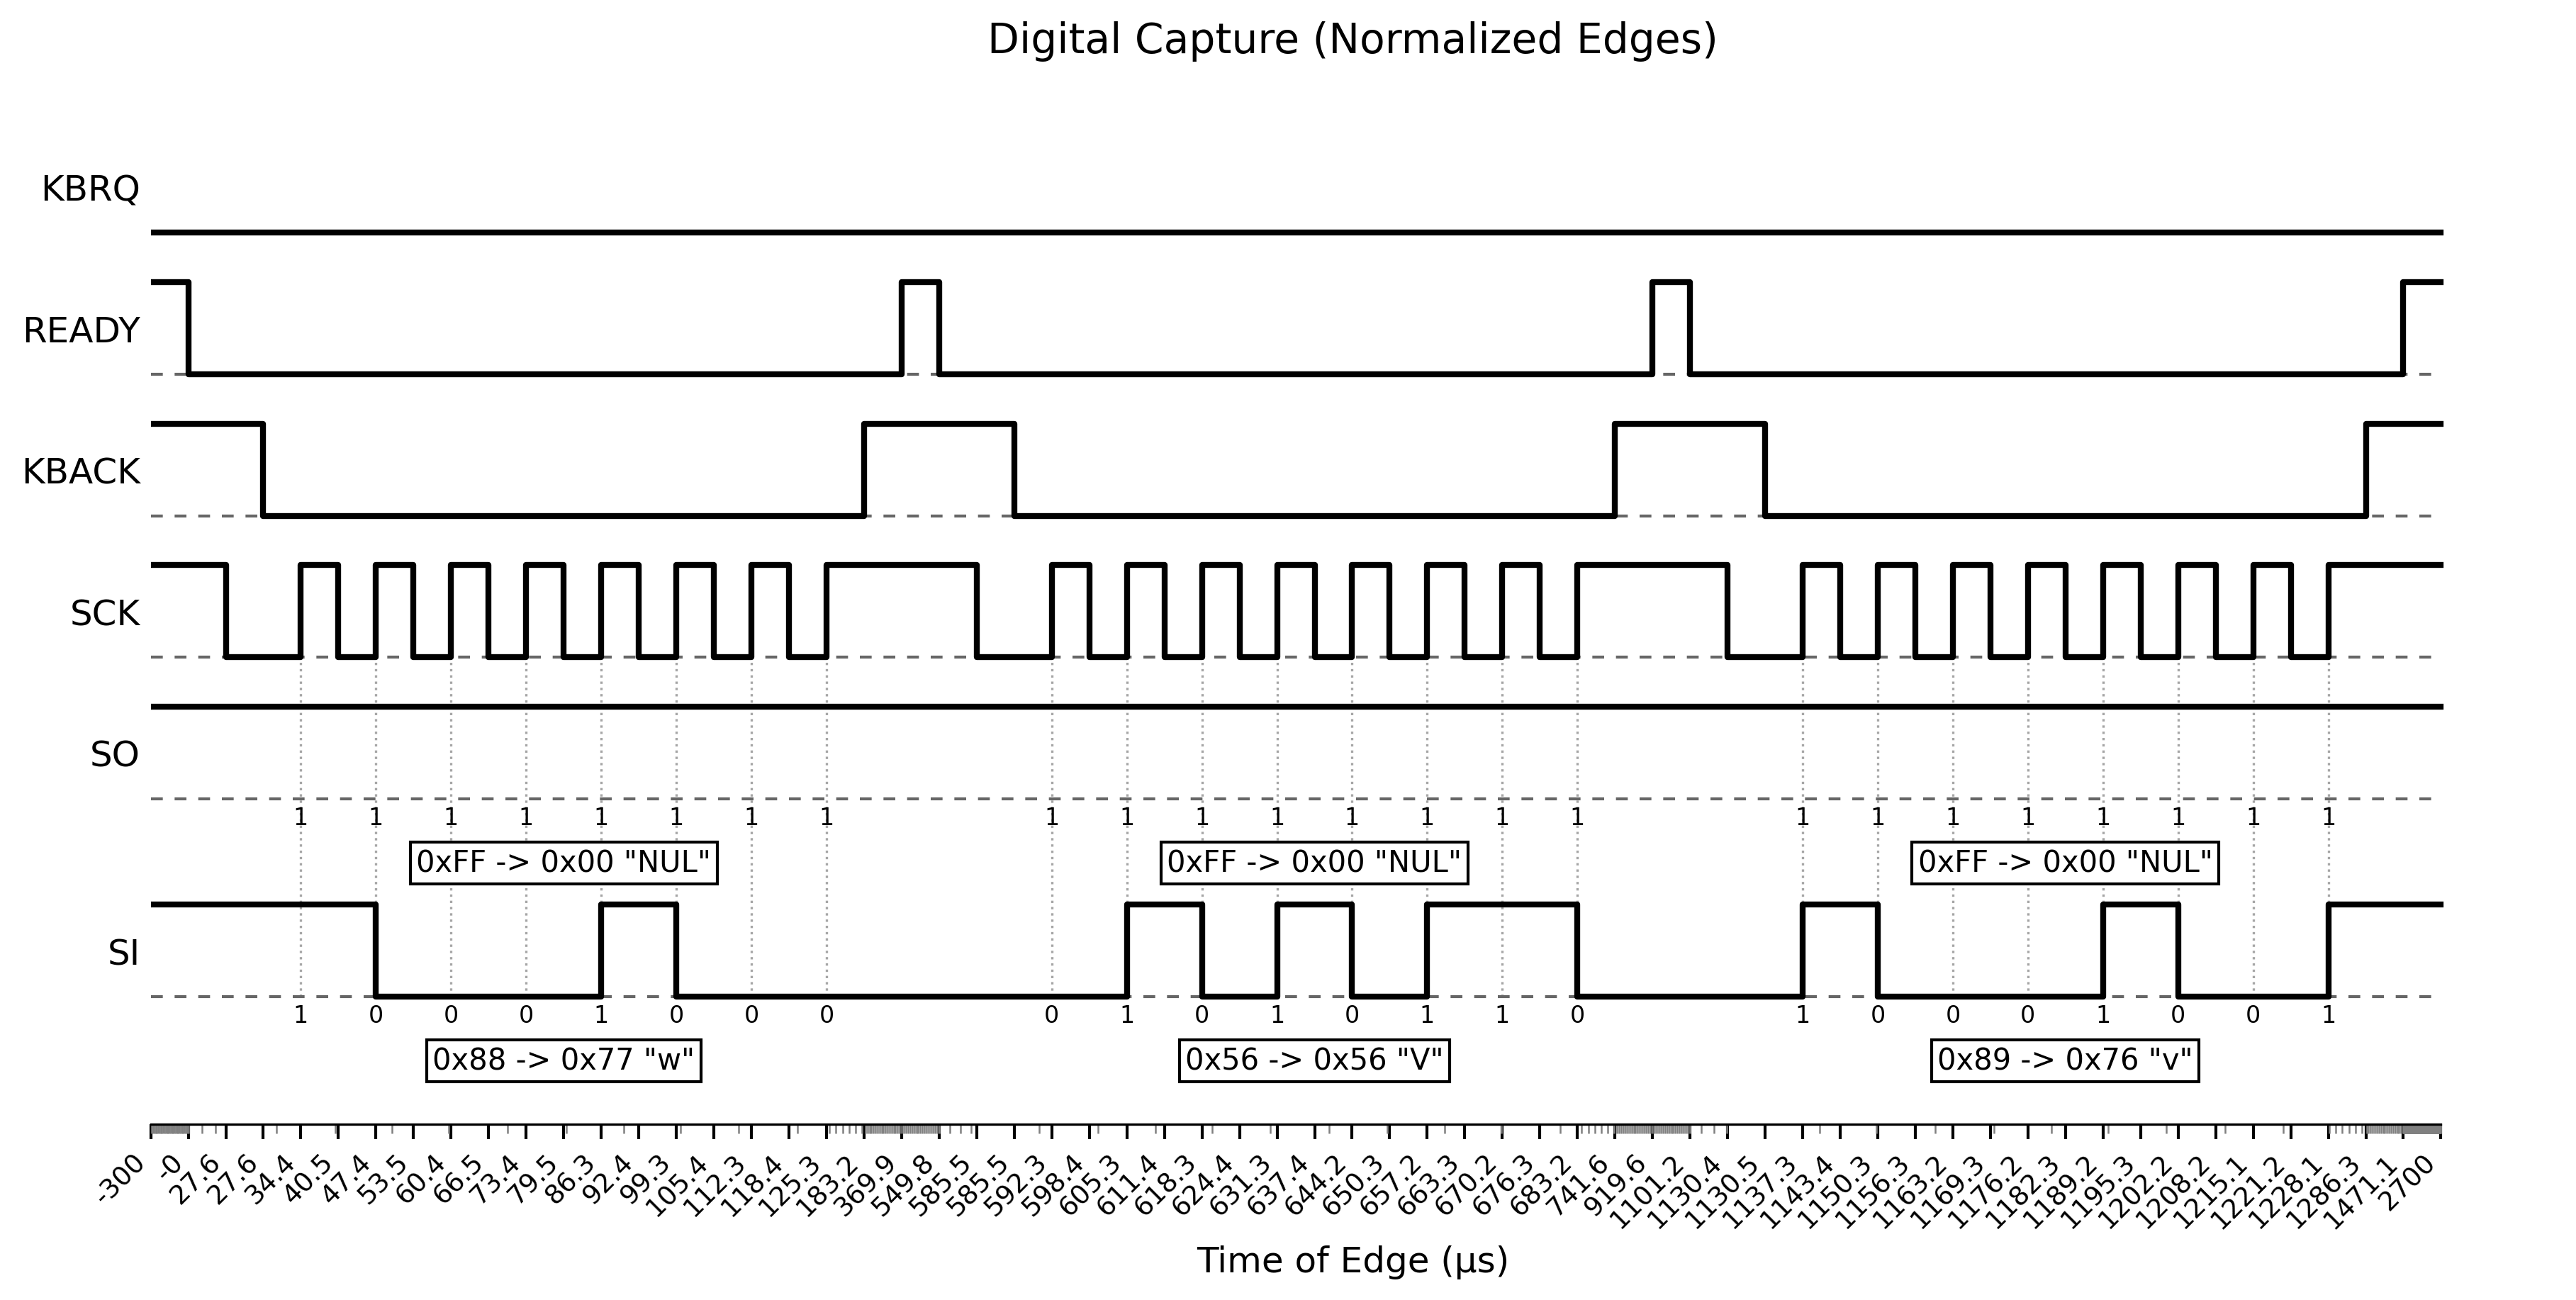

Saved to: signal_captures/CE650_IF60/CE650_IF60_ASCII_94_SPECIAL.pkl

PC: 94 "^"
RAW-SI: 0b10001000, 0b01010111, 0b10001001
RAW-SO: 0b11111111, 0b11111111, 0b11111111
DEC-SI: w,W,v
DEC-SO: NUL,NUL,NUL


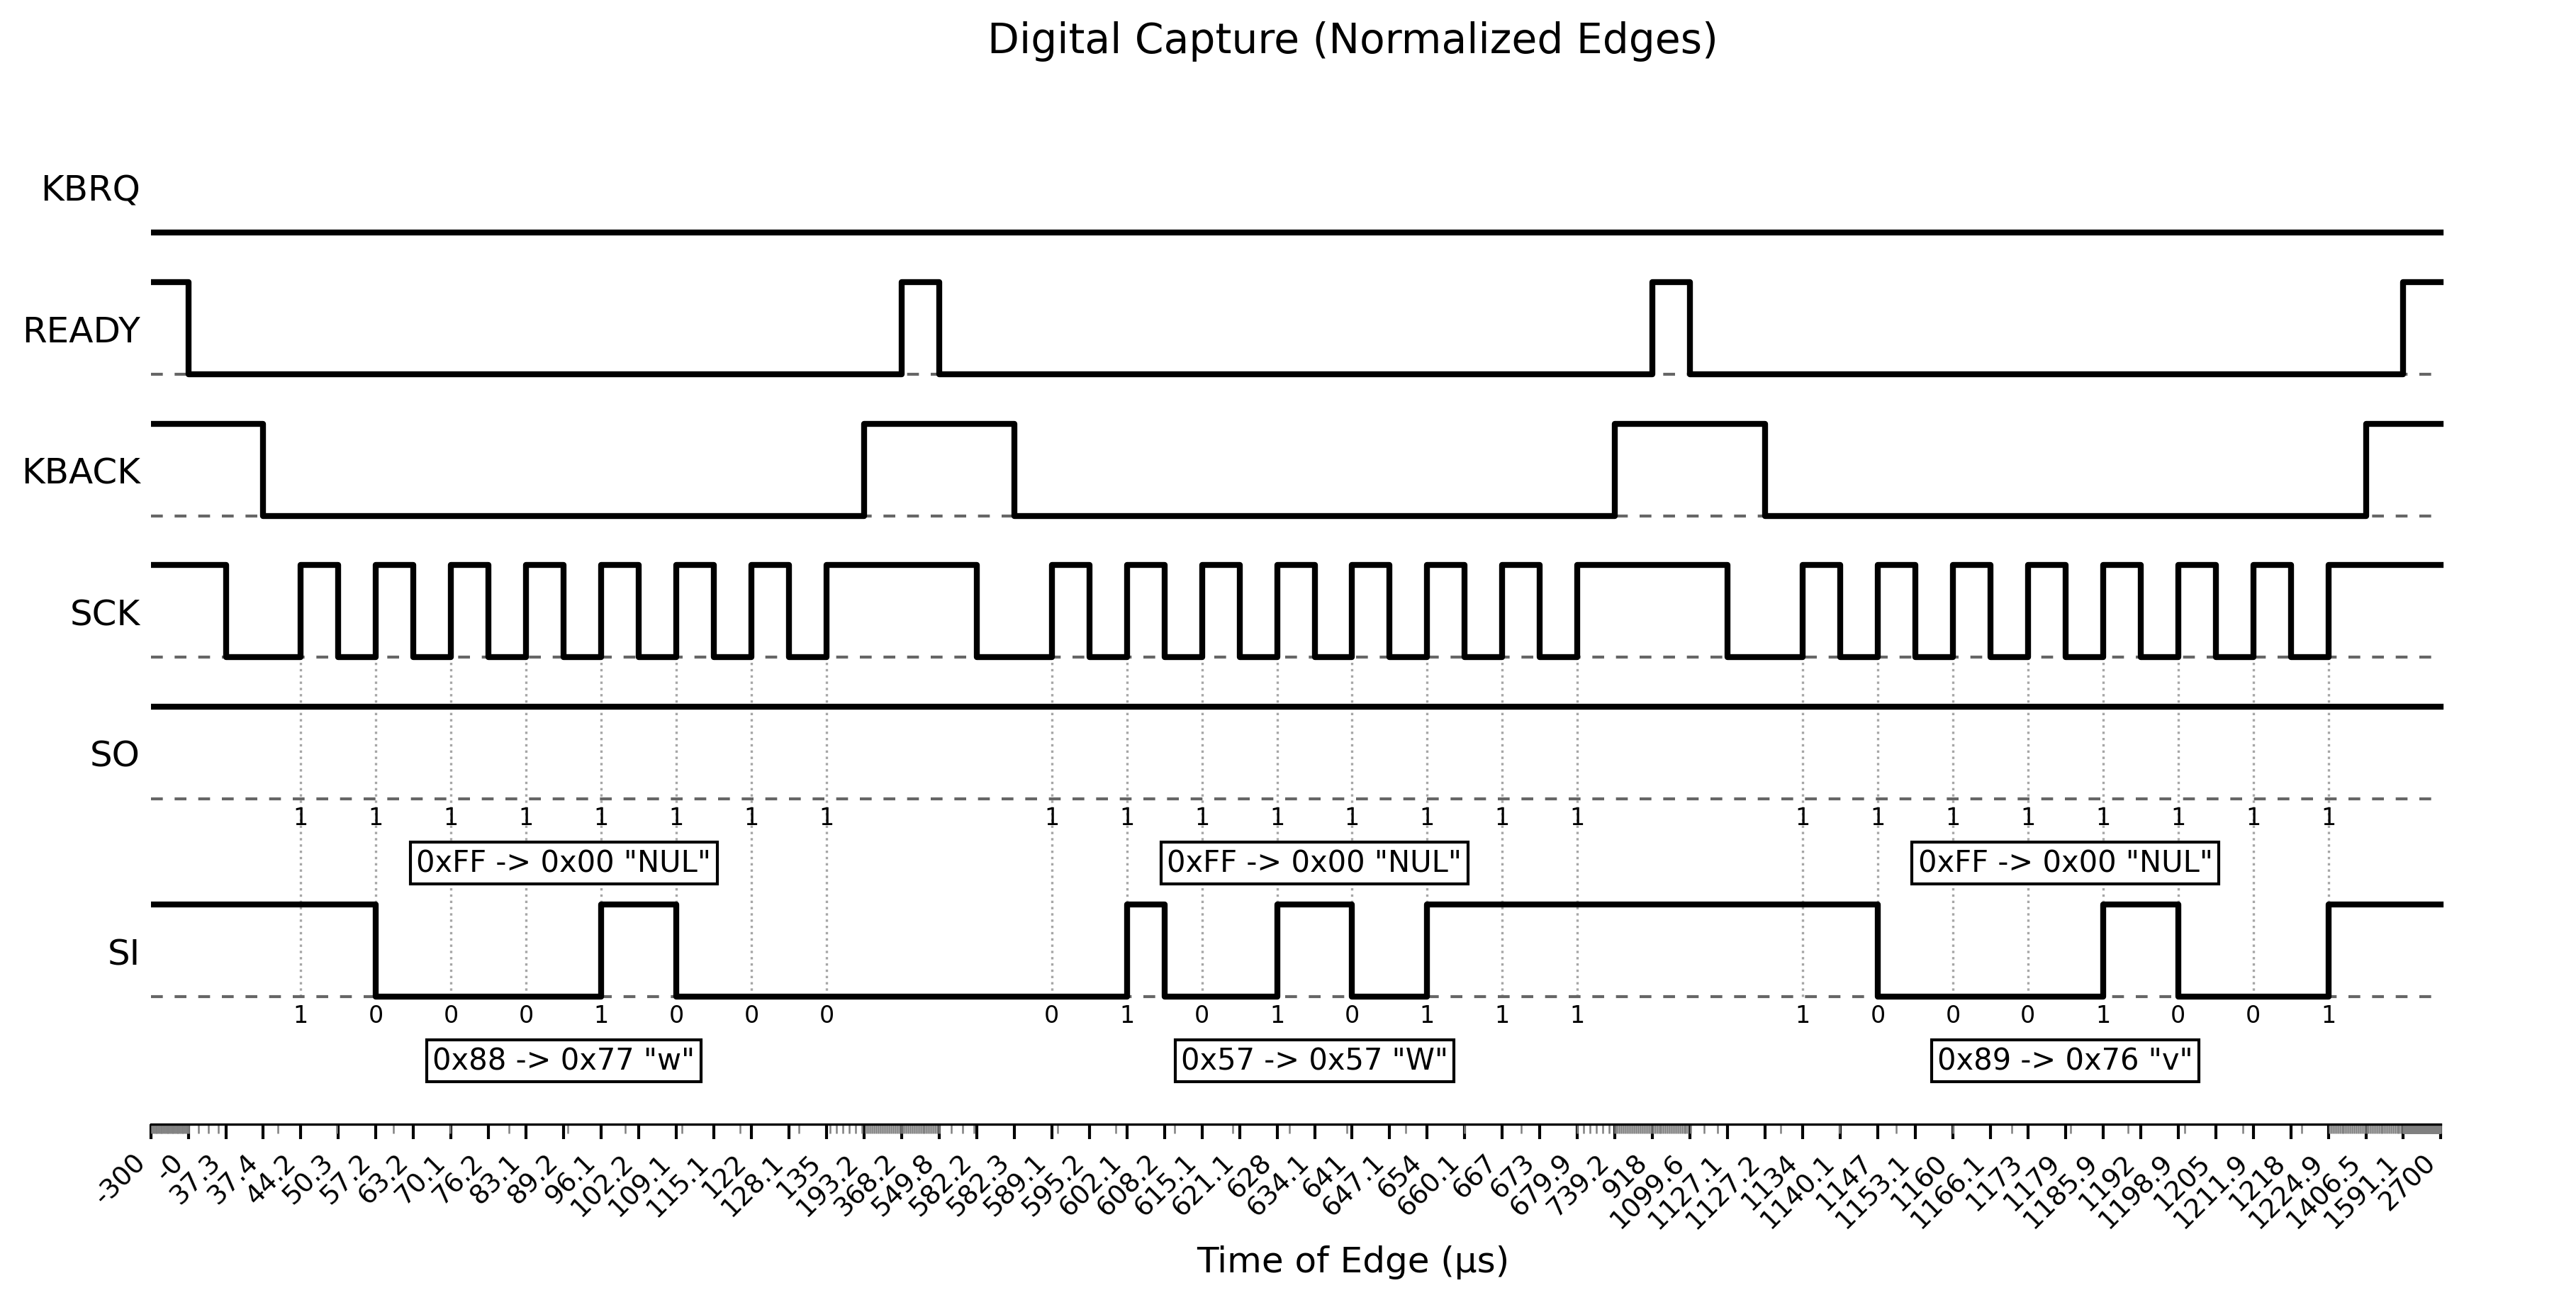

Connection closed


In [12]:
# Capture ABC SPecial
# START WITH INTERFACE IN SELECTED STATE AND TYPEWRITER POWERED OFF AND ON BEFORE!

import numpy as np
import pandas as pd
from analysis_lib.decoder import byte_to_ascii_label

with setup_scope(time_scale=0.3e-3, delay=1.2e-3, trigger_slope="NEGative") as scope:
    with serial.Serial(
        port='/dev/ttyUSB0',
        baudrate=9600,
        bytesize=serial.EIGHTBITS,    # Data Bits: 8
        stopbits=serial.STOPBITS_ONE, # Stop Bits: 1
        parity=serial.PARITY_NONE,    # Parity: None
        rtscts=True,                  # Hardware handshake
        timeout=1
    ) as con:

        # Loop all Chars that where special in the last Transmission
        for i in [60, 62, 94]:
            # Send CR
            con.write(bytes([0x0D]))
            time.sleep(1)

            # Arm the trigger (non-blocking)
            scope.arm_trigger()
            time.sleep(0.2)

            # Send Char
            con.write(bytes([i]))
            time.sleep(1)

            # Read the captured data
            time_data, packed, channel_data = scope.read_current_pod_data(pod=1, mode='RAW')

            # Create structured Capture with metadata
            capture = Capture.from_scope_data(
                time_data, packed, channel_data,
                typewriter=TYPEWRITER,
                interface=INTERFACE,
                name=f"ASCII_{i}_SPECIAL",
                info=f'Transmission from IF60 to CE650, after sending Ascii letter "{chr(i)}" to IF60 from PC. More then One Byte is send',
                keyboard_setting=KEYBOARD,
                interface_dip_switches=DIP_SWITCHES
            )

            # Print Captrure Info
            # print(f"\n{capture.get_info()}")
            # Save Capture to file
            # filepath = capture.save(directory=f"./signal_captures/{TYPEWRITER}_{INTERFACE}")
            # print(f"Saved to: {filepath}\n")

            # Decode and Debounce Raw Bits
            raw_decoder = RawDecoder(channel_data, time_data)
            raw_si: RawDecodeResult = raw_decoder.decode(data_ch=0)
            raw_so: RawDecodeResult = raw_decoder.decode(data_ch=1)
            print(f'PC: {i} "{byte_to_ascii_label(i)}"')
            print(f"RAW-SI: {raw_si}\nRAW-SO: {raw_so}")

            decoded_si = BrotherSerialDecoder(raw_si).decode()
            decoded_so = BrotherSerialDecoder(raw_so).decode()
            print(f"DEC-SI: {decoded_si}\nDEC-SO: {decoded_so}")

            # Plot with annotations
            annotations = (decoded_si.to_annotations(include_bits=True) + decoded_so.to_annotations(include_bits=True))

            # plot_digital(time_data, channel_data)
            plot_digital_normalized(time_data, channel_data, annotations=annotations)

Connected to: AGILENT TECHNOLOGIES,MSO7014A,MY49110266,06.20.0000
Digital channels [0, 1, 2, 3, 4, 5] enabled, threshold=2.5V
Edge trigger on D4, slope=NEGative
Connection closed

Capture: DESELECT
Timestamp: 2026-01-26 19:22:41
Devices: CE650 / IF60
Data: 1.00 MHz, Channels: 0:SI, 1:SO, 2:SCK, 3:KBACK, 4:READY, 5:KBRQ, 6:D6, 7:D7
Notes: Handshake between IF60 and CE650, after Transmission of DC3(Deactivates SEL Mode) from PC to Interface
Saved to: signal_captures/CE650_IF60/CE650_IF60_DESELECT.pkl

RAW-SI: 0b11110010, 0b11111000
RAW-SO: 0b11111111, 0b11111111
DEC-SI: CR,BEL
DEC-SO: NUL,NUL


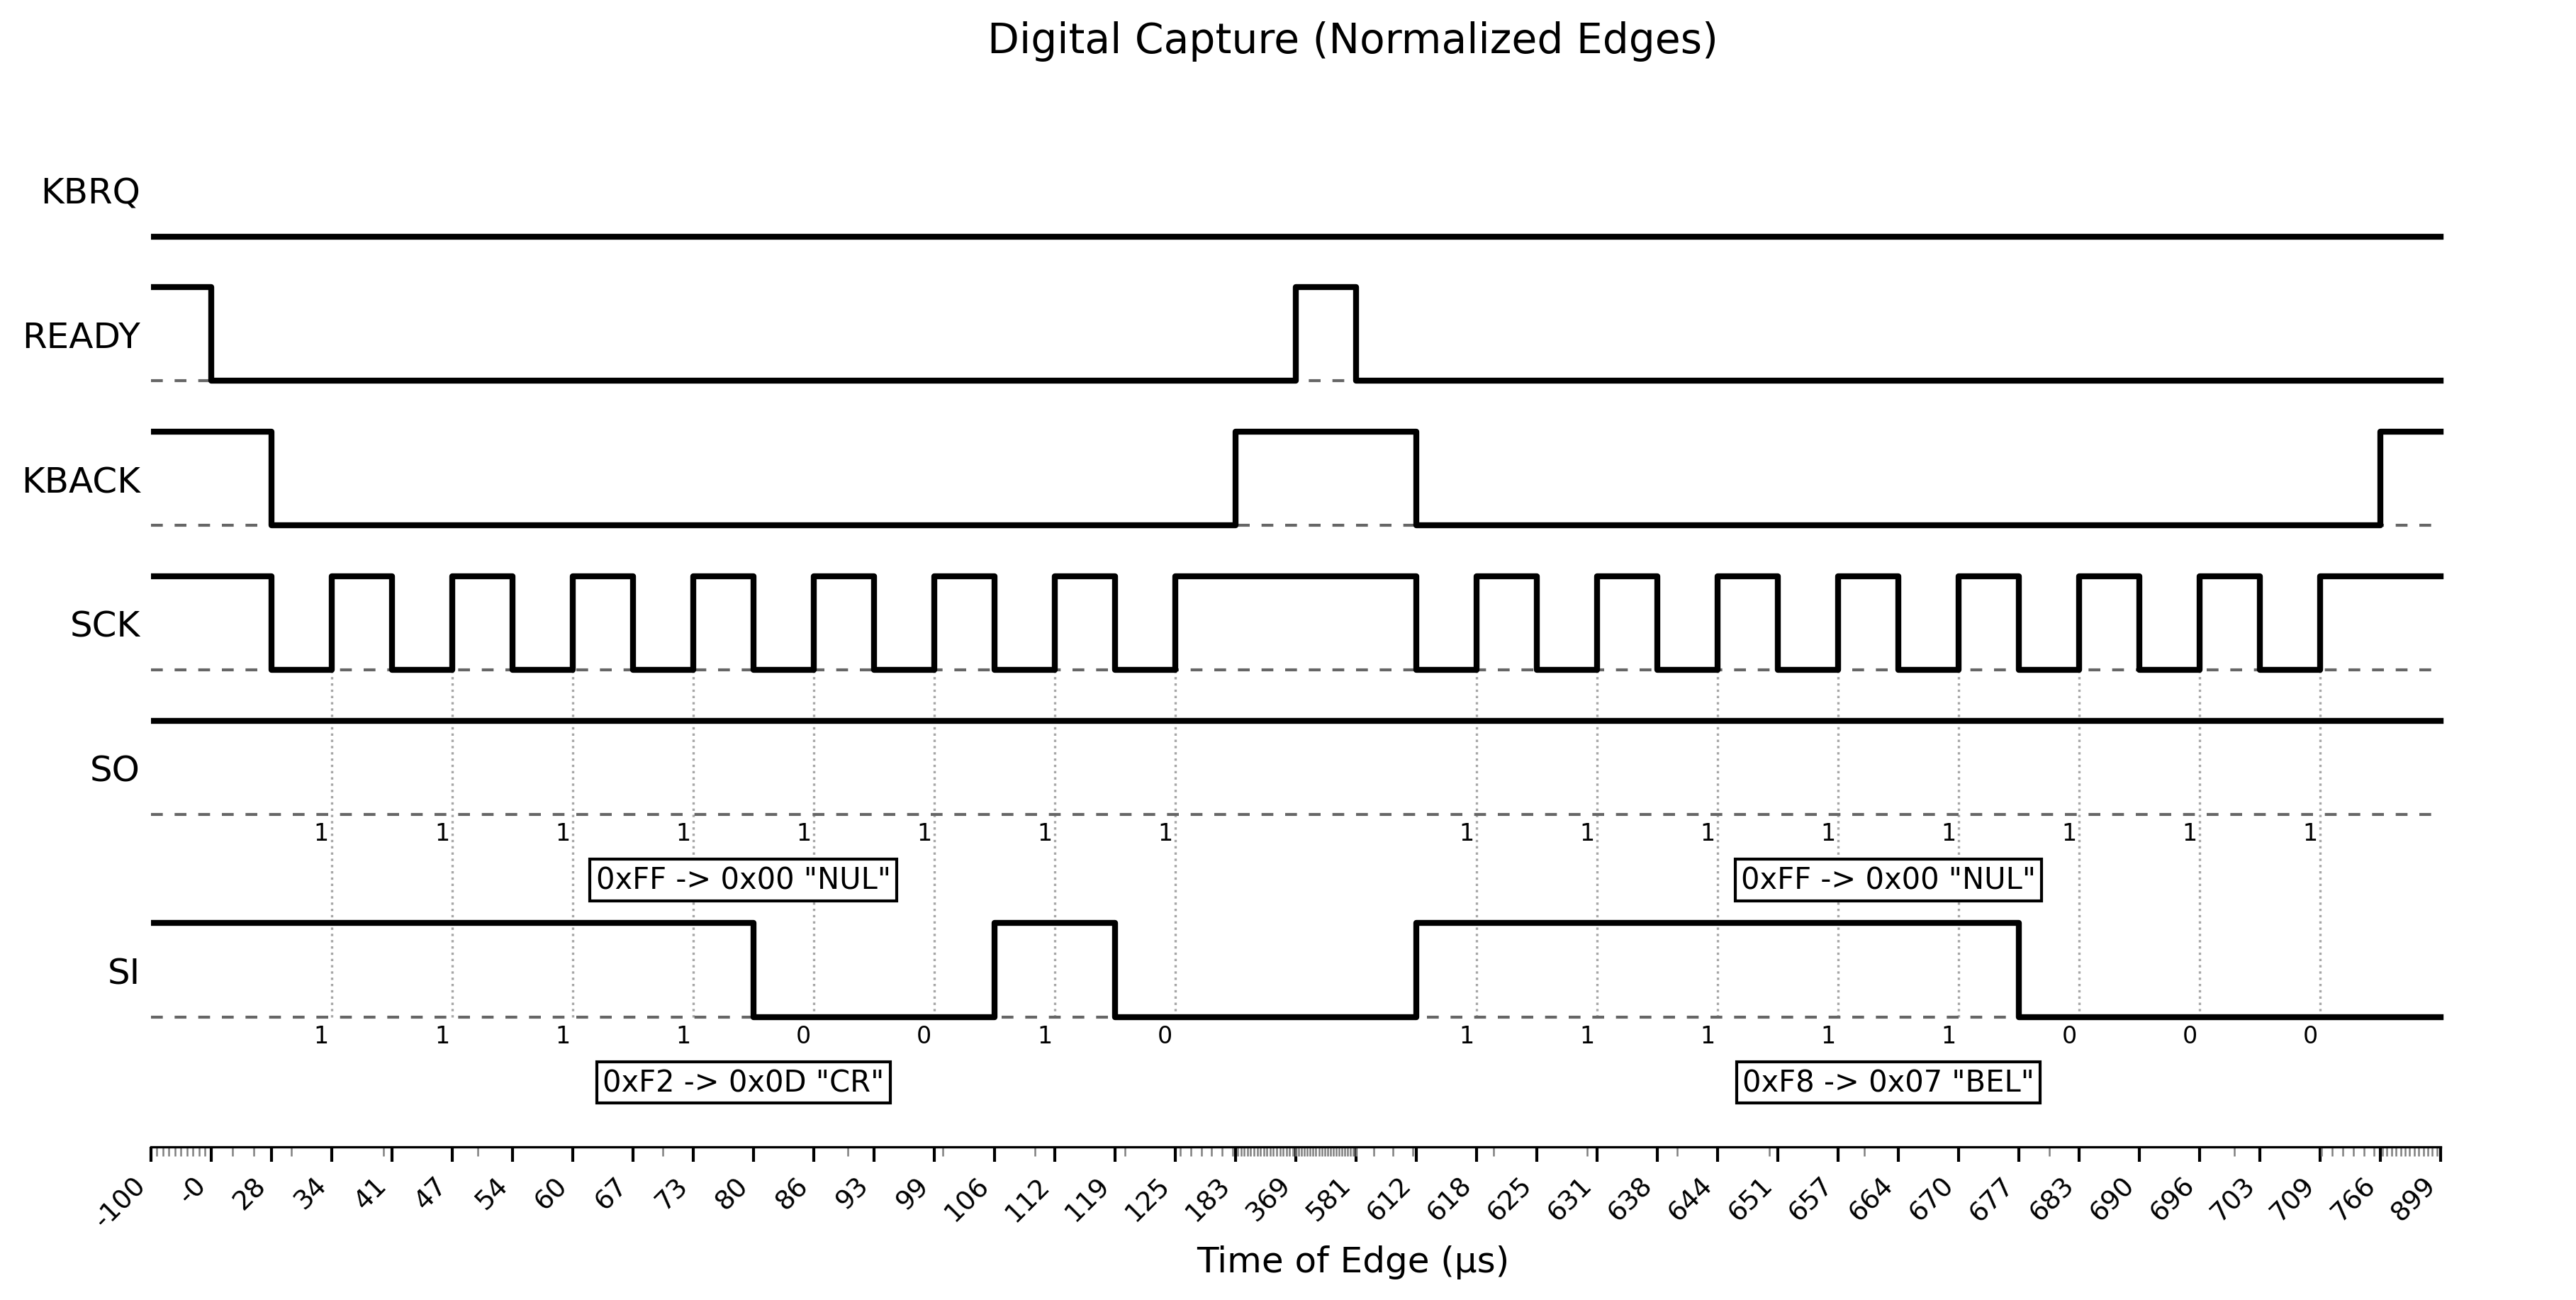

(<Figure size 3600x1800 with 1 Axes>,
 <Axes: title={'center': 'Digital Capture (Normalized Edges)'}, xlabel='Time of Edge (µs)'>)

In [13]:
# Capture DESELECT
# START WITH INTERFACE IN DESELECTED STATE AND TYPEWRITER POWERED OFF AND ON BEFORE!
NAME = "DESELECT"
INFO = "Handshake between IF60 and CE650, after Transmission of DC3(Deactivates SEL Mode) from PC to Interface"

with setup_scope(time_scale=1e-4, delay=4e-4, trigger_slope="NEGative") as scope:
    with serial.Serial(
        port='/dev/ttyUSB0',
        baudrate=9600,
        bytesize=serial.EIGHTBITS,    # Data Bits: 8
        stopbits=serial.STOPBITS_ONE, # Stop Bits: 1
        parity=serial.PARITY_NONE,    # Parity: None
        rtscts=True,                  # Hardware handshake
        timeout=1
    ) as con:

        # Arm the trigger (non-blocking)
        scope.arm_trigger()
        time.sleep(0.2)

        # DC1 Put IF-60 into Select State
        con.write(bytes([0x13]))
        time.sleep(5)

        # Read the captured data
        time_data, packed, channel_data = scope.read_current_pod_data(pod=1, mode='NORMal')

# Create structured Capture with metadata
capture = Capture.from_scope_data(
    time_data, packed, channel_data,
    typewriter=TYPEWRITER,
    interface=INTERFACE,
    name=NAME,
    info=INFO,
    keyboard_setting=KEYBOARD,
    interface_dip_switches=DIP_SWITCHES
)

# Print Captrure Info
print(f"\n{capture.get_info()}")
# Save Capture to file
# filepath = capture.save(directory=f"./signal_captures/{TYPEWRITER}_{INTERFACE}")
# print(f"Saved to: {filepath}\n")

# Decode and Debounce Raw Bits
raw_decoder = RawDecoder(channel_data, time_data)
raw_si: RawDecodeResult = raw_decoder.decode(data_ch=0)
raw_so: RawDecodeResult = raw_decoder.decode(data_ch=1)
print(f"RAW-SI: {raw_si}\nRAW-SO: {raw_so}")

decoded_si = BrotherSerialDecoder(raw_si).decode()
decoded_so = BrotherSerialDecoder(raw_so).decode()
print(f"DEC-SI: {decoded_si}\nDEC-SO: {decoded_so}")

# Plot with annotations
annotations = (decoded_si.to_annotations(include_bits=True) + decoded_so.to_annotations(include_bits=True))

# plot_digital(time_data, channel_data)
plot_digital_normalized(time_data, channel_data, annotations=annotations)
